<a href="https://colab.research.google.com/github/CristaldoWeint/M72_03_Gesti-n-y-procesamiento-de-base-de-datos-y-nociones-de-auditor-a-no-presencial/blob/main/T2_ANP_MAURICIO_CRISTALDO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

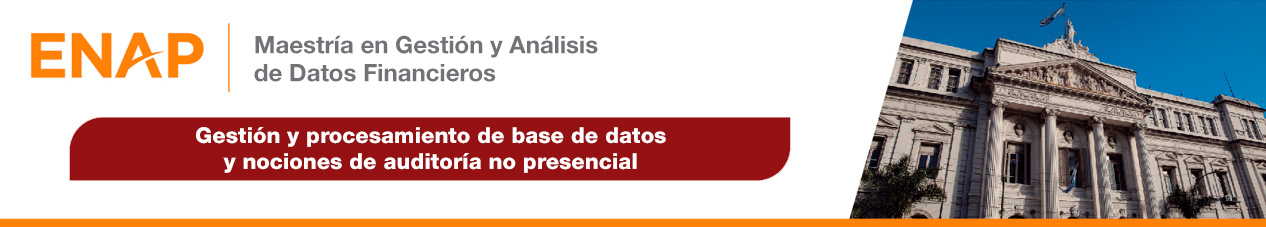

# **GESTIÓN Y PROCESAMIENTO DE BASE DE DATOS Y NOCIONES DE AUDITORÍA NO PRESENCIAL**


Escuela de Negocios y Administración Pública

Facultad de Ciencias Económicas - Universidad de Buenos Aires


#Trabajo Práctico

>Profresores: Carolina Castro, Alberto Falco

>Alumno: Mauricio Emanuel Cristaldo Valenzuela

# Trabajo de campo


---



##**Informe Detallado de Auditoría Interna sobre el Proceso de Predicción de Morosidad y Cumplimiento Normativo en el Módulo Marketing.**
* Entidad Auditada: Banco XXX,
* Proceso Específico Auditado: Proceso de predicción de morosidad y cumplimiento de la Ley 26.951 ("No Llame") utilizando datos del módulo Marketing,
*Período Cubierto por la Auditoría: Ejercicio X1
Equipo de Auditoría: Equipo de Auditoría Interna del Banco XXX,
*Destinatario Principal: Equipo de Riesgo del Banco XXX (y otros que se definan en la sección de Distribución).
*Fecha de Emisión del Informe:







----
Recopilación de Datos: Obtención del conjunto de datos del módulo Marketing correspondiente al ejercicio X1.

# 0 - Bibliotecas y obtencion de datos


---



En el presente apartado se obtiene las blbiotecas, el dataset bajo evaluación y se realiza una visualización de las variables obtenidas.

In [1]:
# Instalación de paquetes (solo necesario una vez)
!pip install ucimlrepo

# Bibliotecas básicas
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Bibliotecas para visualización
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Bibliotecas para preprocesamiento
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Bibliotecas para modelado y muestreo
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Bibliotecas para evaluación y validación
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    precision_recall_fscore_support,
    make_scorer,
    recall_score,
    precision_score,
    f1_score,
    auc
)

# Biblioteca para importar datasets
from ucimlrepo import fetch_ucirepo

# Imputación
from sklearn.impute import KNNImputer

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features #corresponde al set de datos del archivo bank-full.csv
X_0 = X.copy() #Se deja copia del df original
bank_marketing.variables


,name,role,type,demographic,description,units,missing_values
0,age,Feature,Integer,Age,None,None,no
1,job,Feature,Categorical,Occupation,"type of job (categorical: 'admin.','blue-colla...",None,no
2,marital,Feature,Categorical,Marital Status,"marital status (categorical: 'divorced','marri...",None,no
3,education,Feature,Categorical,Education Level,"(categorical: 'basic.4y','basic.6y','basic.9y'...",None,no
4,default,Feature,Binary,None,has credit in default?,None,no
5,balance,Feature,Integer,None,average yearly balance,euros,no
6,housing,Feature,Binary,None,has housing loan?,None,no
7,loan,Feature,Binary,None,has personal loan?,None,no
8,contact,Feature,Categorical,None,contact communication type (categorical: 'cell...,None,yes
9,day_of_week,Feature,Date,None,last contact day of the week,None,no


# VARIABLES DE ENTRADA INDICADAS POR EL BANCO:

* Datos del cliente bancario:

1.  Edad (numérico)
2.  Trabajo: Tipo de trabajo (categórico: "administrador", "desconocido", "desempleado", "gerente", "empleado doméstico", "empresario",
"estudiante", "obrero", "autónomo", "jubilado", "técnico", "servicios")
3.  Estado civil: Estado civil (categórico: "casado", "divorciado", "soltero"; nota: "divorciado" significa divorciado o viudo)
4.  Educación (categórico: "desconocido", "secundario", "primario", "terciario")
5.  Morosidad: ¿Tiene un crédito en mora? (binario: "sí", "no")
6.  Saldo: Saldo medio anual, en euros (numérico)
7.  Hipoteca: ¿Tiene un préstamo hipotecario? (binario: "sí", "no")
8. Préstamo: ¿Tiene un préstamo personal? (binario: "sí", "no")

* Relacionado con el último contacto de la campaña actual:

9. contacto: tipo de comunicación del contacto (categórico: "desconocido", "teléfono", "celular")
10. día: día del último contacto del mes (numérico)
11. mes: mes del último contacto del año (categórico: "ene", "feb", "mar", ..., "nov", "dic")
12. duración: duración del último contacto, en segundos (numérico)

* Otros atributos:

13. campaña: número de contactos realizados durante esta campaña y para este cliente (numérico, incluye el último contacto)
14. pdays: número de días transcurridos desde el último contacto con el cliente de una campaña anterior (numérico, -1 significa que el cliente no fue contactado previamente)
15. anterior: número de contactos realizados antes de esta campaña y para este cliente (numérico)
16. poutcome: resultado de la campaña de marketing anterior (categórico: "desconocido", "otro", "fracaso", "éxito")

# ANÁLISIS DE LA CALIDAD DE LOS DATOS


---


Revisión exhaustiva de los datos originales para identificar valores faltantes, inconsistencias, y problemas de formato en las variables relevantes.


# 1- Calidad de los datos:

 1. Validez
 2. Completitud
 3. Unicidad


##  1.1 VALIDEZ / CONFORMIDAD

In [4]:
print("--- 1. VALIDEZ / CONFORMIDAD ---")
# a) Tipos de datos
print("a) Tipos de datos por columna:")
print(X.dtypes)

print("\nVisualizacion del set de datos a evaluar")
print(X.head(10))

print("\nDimensiones del DataFrame 2017_Financial_Data:", X.shape)


print("\nRecuento de valores únicos por atributo")
for col in X.columns:
  print(col, ":", X[col].nunique())


print("\nValores únicos por atributo")
print("job: ",X['job'].unique())
print("contact: ",X['contact'].unique())
print("marital: ",X['marital'].unique())
print("edutacion: ",X['education'].unique())
print("poutcome: ",X['poutcome'].unique())

--- 1. VALIDEZ / CONFORMIDAD ---
a) Tipos de datos por columna:
age             int64
job            object
marital        object
education      object
default        object
balance         int64
housing        object
loan           object
contact        object
day_of_week     int64
month          object
duration        int64
campaign        int64
pdays           int64
previous        int64
poutcome       object
dtype: object

Visualizacion del set de datos a evaluar
   age           job   marital  education default  balance housing loan  \
0   58    management   married   tertiary      no     2143     yes   no   
1   44    technician    single  secondary      no       29     yes   no   
2   33  entrepreneur   married  secondary      no        2     yes  yes   
3   47   blue-collar   married        NaN      no     1506     yes   no   
4   33           NaN    single        NaN      no        1      no   no   
5   35    management   married   tertiary      no      231     yes   no   
6  

* De los datos obtenidos se puede visualizar las variables binarias como default, housing y loan.
* Algunas categorias como en conctac y putoutcome el estado 0 es estado desconocido, y se considera igual a NaN (*missing values*) lo que es un error en el entendimiento de la variable dado que la falta de un valor puede deberse a otros motivos y el estado uknown puede estar debeidamente registrado. Es decir puede existir valores de estados 1 y 2 que puede ser Nan, pero por pólitica del Banco se considera igual de Uknownw

## 1-2 COMPLETITUD (Valores Faltantes)

In [5]:
print("--- 2. COMPLETITUD (Valores Faltantes) ---")

print("\nExplorando la cantidad de valores perdidos en las variables")
X.isna().sum()/X.shape[0]*100

--- 2. COMPLETITUD (Valores Faltantes) ---

Explorando la cantidad de valores perdidos en las variables


,0
age,0.000000
job,0.637013
marital,0.000000
education,4.107407
default,0.000000
balance,0.000000
housing,0.000000
loan,0.000000
contact,28.798301
day_of_week,0.000000



Visualizacion de datos faltantes por metrica


<Axes: >

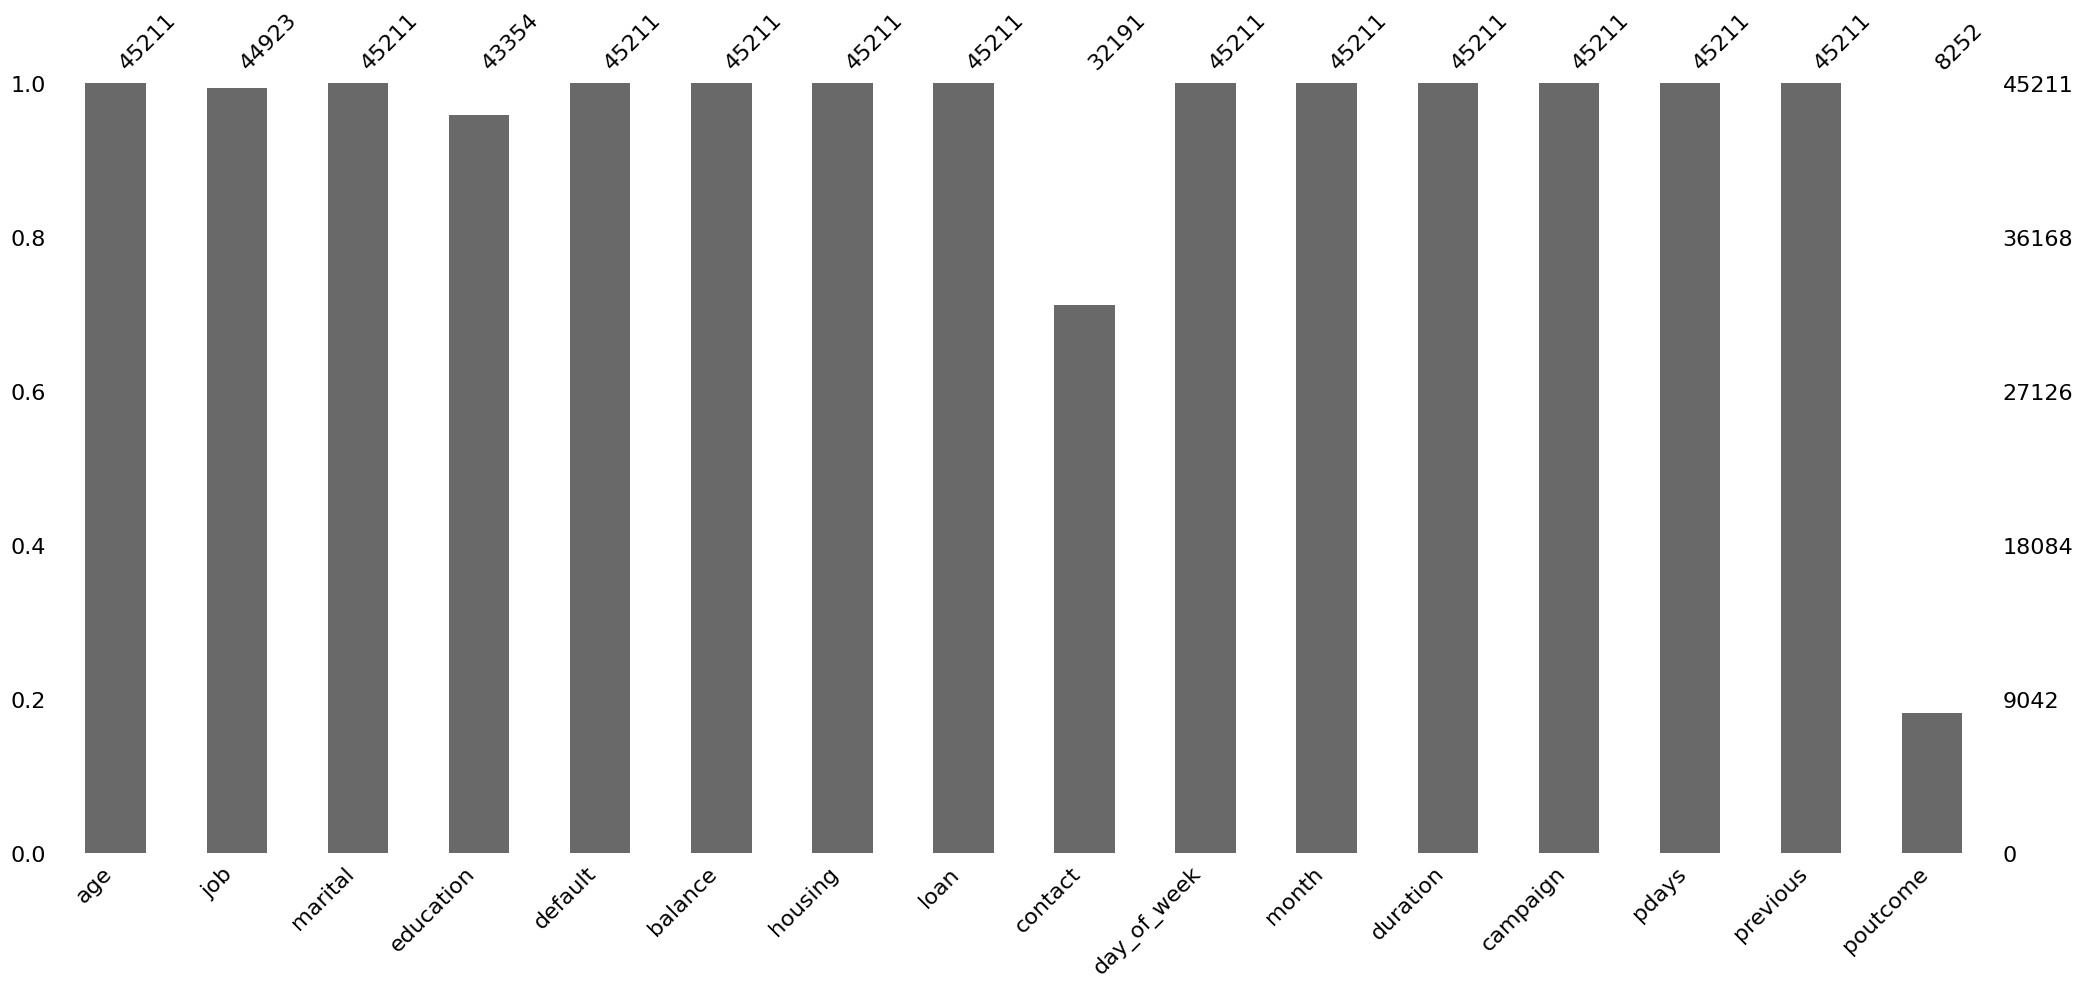

In [6]:
# bar missing
print("\nVisualizacion de datos faltantes por metrica")
msno.bar(X)


Visualizacion de datos faltantes por metrica


<Axes: >

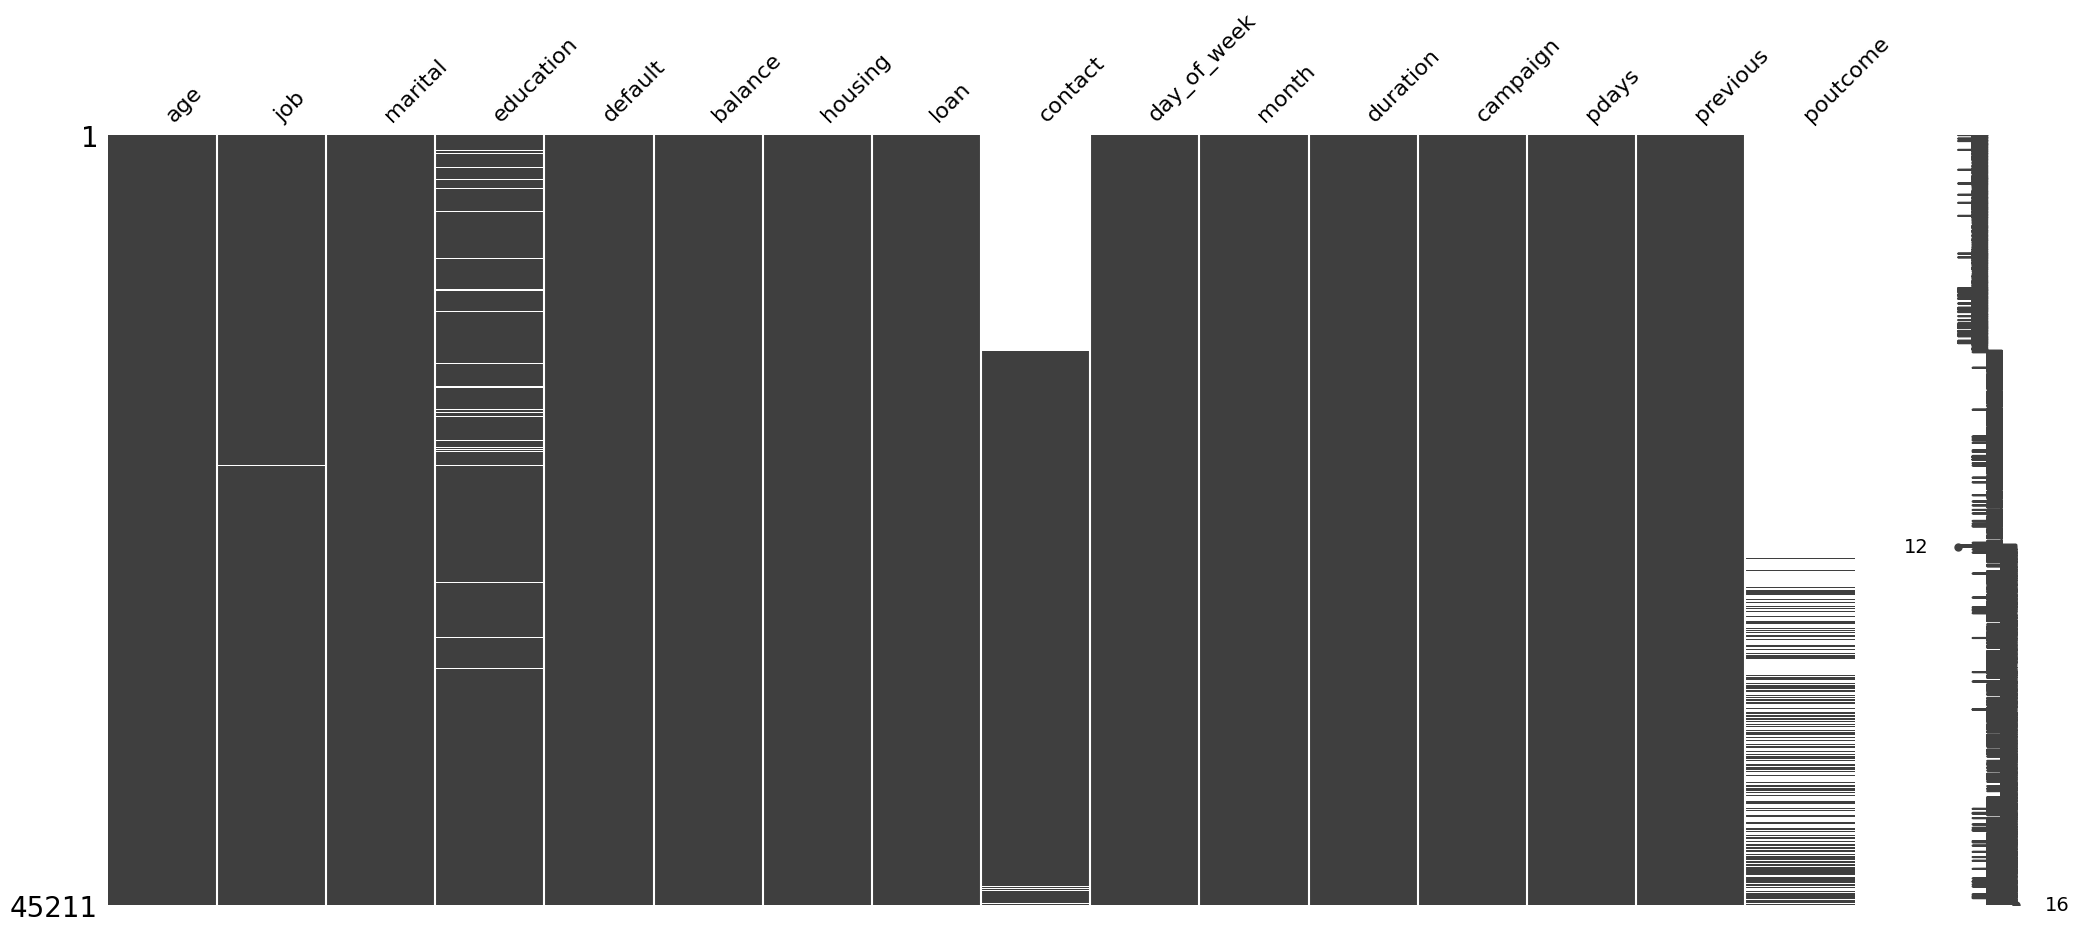

In [7]:
# matrix missing
print("\nVisualizacion de datos faltantes por metrica")
msno.matrix(X)

* Se observa datos faltantes en las variables job, education, contact y poutcome con 0,63%, 4,17&, 28,8% y 81,8% respectivamente.

* se visualiza una concentracion de faltantes en contact en los primeros registros, los primeros 28% aprox de registros cuentan con datos faltantes

* Se visualiza una falta significativa del estado de campaña anterior *poutcome*, principalmente en el primer 60% de la base y luego con concentraciones cercanas a final de la base pero con grandes espacios de datos faltantes.

## 1-3 UNICIDAD (Duplicados)

In [8]:
# --- 3. Unicidad (Duplicates) ---
print("--- 3. UNICIDAD (Duplicados) ---")
duplicate_rows = X.duplicated()
num_duplicate_rows = duplicate_rows.sum()
print(f"Número de filas completamente duplicadas: {num_duplicate_rows}")
if num_duplicate_rows > 0:
    print("Filas duplicadas:")
    print(X[duplicate_rows])


--- 3. UNICIDAD (Duplicados) ---
Número de filas completamente duplicadas: 0


##  1-4 Observaciones del set de datos las variables:


---



* Las variables Trabajo, Educación, Contacto y *Poutcome* incluyen un valor explícito "desconocido" como categoría válida, además de valores faltantes (NaN), lo que indica una distinción entre datos no registrados (NaN) y datos registrados como desconocidos por el sistema o el proceso de recolección. Esta duplicidad puede generar confusión en el análisis y afectar la calidad de las predicciones.





  * Trabajo (*job*) posee un nivel poco significativo de registros faltantes (288 que corresponden al 0,63% de los registros),
  * Eduación (*education*) en el mismo nivel posee 1.857 registros faltantes que corresponde al 4,1% de la base y
  * Teléfono de contacto (*contact*) posee registros faltantes por el 30% de la base y
  * Resultado de campaña anterior (*poutcome*) 81,75% de la base siento el más signicativo de todas las observaciones.


  > Plan de acción sugerido en todos los casos se sugiere la busqueda de la información real en especial aquellos que por su cantidad trabajo 288 y educacion 857 se pueden recuperar con esperada facilidad;

  > Para realizar el análisis de pérfiles de riesgos se procede a:

  * Convertir variables binarias "sí"/"no" a 1/0
      (*default, housing, loan, contact*)
  * Convertir a numércias categoricas a las variables tipo object: *job, marital, education, default, housing, loan, contact, month* (numero por indentificador del mes) y *poutcome*
  * Dado lo significativo en los *missing values* se reconcera a las faltantes como desconocido = 0
  * Para los datos faltantes se utiliza random tree para mejor rendimiento de las variables categoricas.







### Imputación de Datos Faltantes: Para las variables con datos faltantes
---
Se aplica un procedimiento de imputación utilizando un modelo Random Forest.
Las variables categóricas con valores faltantes fueron transformadas mediante la creación de variables dummy antes de la imputación.

### 1-A Preparación de los datos


1. Asinacion de 1 si - 0 no
2. Asignacion de numero de mes
3. Pasar de objet a numericas al resto
4. Randomtrees para valores faltantes
5. Creación de variable dummy para mejorar el rendimiento del predictor.

In [9]:
print("\n--- A.1 Categorizar las variables binarias ---")
cols_binarias = ['default', 'housing', 'loan']
for col in cols_binarias:
    X.loc[:,col] = X[col].map({'yes': 1, 'no': 0}).astype(float)
    print("Columna binarias corregidos", col ,X[col].unique())

print("\n--- A.2 Categorizar correcamente los meses ---")

print("Meses del df: ",X['month'].unique())

mes_orden = {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}
if 'month' in X.columns and X['month'].dtype == 'object':
    X.loc[:,'month'] = X['month'].map(mes_orden).astype(float)

print("Meses corregidos",X['month'].unique())

print("\n--- A.3 Convertir variables tipo object a tipo numérico (excluyendo 'month' y columnas binarias) ---")
cols_object = X.select_dtypes(include=['object']).columns.tolist()
cols_to_encode = [col for col in cols_object if col not in cols_binarias + ['month']]


print("Columnas a codificar:", cols_to_encode)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',  unknown_value=-1)
X[cols_to_encode] = encoder.fit_transform(X[cols_to_encode])
# Mapear -1 a 0
for col in cols_to_encode:
    X.loc[X[col] == -1, col] = 0
    X.loc[:, col] = X[col].astype(float)  # float para NaN


print("\n--- A.4 Correción categria contacto ---")
mapeo_valores_existentes = {
    0.0: 1,  # Los que eran 0 (ej. "telephone") ahora serán 1
    1.0: 2   # Los que eran 1 (ej. "cellular") ahora serán 2
}
X['contact'] = X['contact'].map(mapeo_valores_existentes)
X['contact'] = X['contact'].fillna(0)
X['contact'] = X['contact'].astype(int)
X['contact'].head()

print("\n--- A.5 Mapear NaN a 0 en poutcome ---")
if 'poutcome' in X.columns:
    X.loc[X['poutcome'].isna(), 'poutcome'] = 0

print("\n--- A.6 Variable dummy para imputar valores faltantes ---")

for col in X.columns:
    if X[col].isnull().sum() > 0:
        nueva_columna = 'MARCA_' + col
        X[nueva_columna] = X[col].isnull().astype(int)



# Eliminar esas columnas
X.head()


--- A.1 Categorizar las variables binarias ---
Columna binarias corregidos default [0.0 1.0]
Columna binarias corregidos housing [1.0 0.0]
Columna binarias corregidos loan [0.0 1.0]

--- A.2 Categorizar correcamente los meses ---
Meses del df:  ['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'jan' 'feb' 'mar' 'apr' 'sep']
Meses corregidos [5.0 6.0 7.0 8.0 10.0 11.0 12.0 1.0 2.0 3.0 4.0 9.0]

--- A.3 Convertir variables tipo object a tipo numérico (excluyendo 'month' y columnas binarias) ---
Columnas a codificar: ['job', 'marital', 'education', 'contact', 'poutcome']


<ipython-input-9-489fcd0ce875>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cols_to_encode] = encoder.fit_transform(X[cols_to_encode])
<ipython-input-9-489fcd0ce875>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['contact'] = X['contact'].map(mapeo_valores_existentes)
<ipython-input-9-489fcd0ce875>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p


--- A.4 Correción categria contacto ---

--- A.5 Mapear NaN a 0 en poutcome ---

--- A.6 Variable dummy para imputar valores faltantes ---


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,MARCA_job,MARCA_education
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,0,5,5.0,261,1,-1,0,0.0,0,0
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,0,5,5.0,151,1,-1,0,0.0,0,0
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,0,5,5.0,76,1,-1,0,0.0,0,0
3,47,1.0,1.0,NaN,0.0,1506,1.0,0.0,0,5,5.0,92,1,-1,0,0.0,0,1
4,33,NaN,2.0,NaN,0.0,1,0.0,0.0,0,5,5.0,198,1,-1,0,0.0,1,1


A.3 Convertir variables tipo object a tipo numérico (excluyendo 'month' y columnas binarias)

> Se utiliza para la conversion OrdinalEncoder que la página de Sckitlearn indica que: La entrada de este transformador debe ser una matriz de enteros o cadenas, que representan los valores que toman las características categóricas (discretas). Las características se convierten a enteros ordinales. Esto genera una sola columna de enteros (de 0 a n_categorías - 1) por característica. Y ayuda a mantener las posiciones de valores faltantes

In [10]:
print("\nValores únicos después de transformaciones:")
cols_with_missing = X.columns[X.isnull().any()].tolist()

print("month:", X['month'].unique() if 'month' in X.columns else "No encontrada")
for col in cols_binarias:
    print(f"{col}: {X[col].unique() if col in X.columns else 'No encontrada'}")
for col in cols_to_encode:
    print(f"{col}: {X[col].unique() if col in X.columns else 'No encontrada'}")
for col in cols_with_missing:
    print(f"MARCA_{col}: {X[f'MARCA_{col}'].unique() if f'MARCA_{col}' in X.columns else 'No encontrada'}")

X = X.round() #Se redondea dado que son todos numeros enteros.

print("\nTipos de datos después de transformaciones:")
print(X.dtypes)
print("Dimensiones de X antes de imputación:", X.shape)


Valores únicos después de transformaciones:
month: [5.0 6.0 7.0 8.0 10.0 11.0 12.0 1.0 2.0 3.0 4.0 9.0]
default: [0.0 1.0]
housing: [1.0 0.0]
loan: [0.0 1.0]
job: [ 4.  9.  2.  1. nan  5.  0.  7.  6. 10.  3.  8.]
marital: [1. 2. 0.]
education: [ 2.  1. nan  0.]
contact: [0 1 2]
poutcome: [0. 1. 2.]
MARCA_job: [0 1]
MARCA_education: [0 1]

Tipos de datos después de transformaciones:
age                  int64
job                float64
marital            float64
education          float64
default             object
balance              int64
housing             object
loan                object
contact              int64
day_of_week          int64
month               object
duration             int64
campaign             int64
pdays                int64
previous             int64
poutcome           float64
MARCA_job            int64
MARCA_education      int64
dtype: object
Dimensiones de X antes de imputación: (45211, 18)


In [11]:
cols_with_missing_after_transform = X.columns[X.isnull().any()].tolist()
print("\nColumnas con valores nulos después de transformaciones:", cols_with_missing_after_transform)


Columnas con valores nulos después de transformaciones: ['job', 'education']


### 1-B Imputar con RandomForestClassifier

n_estimators=100, random_state=0

In [12]:
precision_scorerint("\n--- B Imputador RandomForestClassifier ---")
for col in cols_with_missing_after_transform:
    print(f"Imputando columna {col}...")
    known_data = X[X[col].notna()].copy()  # Copia para evitar SettingWithCopyWarning
    missing_data = X[X[col].isna()].copy()

    if len(missing_data) > 0:
        rf = RandomForestClassifier(n_estimators=100, random_state=0)
        known_data.loc[:, col] = known_data[col].astype('int64')
        rf.fit(known_data.drop(columns=[col]), known_data[col])
        X.loc[X[col].isna(), col] = rf.predict(missing_data.drop(columns=[col]))   # Predecir y asignar valores imputados
    else:
        print(f"No hay valores nulos en {col}, saltando imputación.")


print("\nValores faltantes después de la imputación:")
print(X.isnull().sum())


--- B Imputador RandomForestClassifier ---
Imputando columna job...
Imputando columna education...

Valores faltantes después de la imputación:
age                0
job                0
marital            0
education          0
default            0
balance            0
housing            0
loan               0
contact            0
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome           0
MARCA_job          0
MARCA_education    0
dtype: int64


* Se realizó con exito la imputación.

In [13]:
X_imputed = X.copy() #Se deja copia de Df imputado

columnas_a_eliminar = [col for col in X.columns if col.startswith('MARCA_')]

X = X.drop(columns=columnas_a_eliminar) #Se descartan las variables dummys

# DESARROLLO Y EVALUACIÓN COMPARATIVA DE MODELOS PREDICTIVOS DE MOROSIDAD


---



*	Se analizó el rendimiento del modelo Random Forest del Banco.
*	Se desarrollaron y validaron modelos alternativos (Random Forest, XGBoost, LightGBM) utilizando Python y librerías especializadas (Scikit-learn, XGBoost, LightGBM, Imbalanced-learn). Se aplicó la técnica SMOTE para abordar el desbalance de la clase "default".
*	La evaluación del desempeño de los modelos se basó en métricas como Accuracy, Precision, Recall (especialmente para la clase minoritaria "default"), F1-Score, Curva ROC (AUC-ROC) y Curva Precision-Recall (AUC-PR). Se utilizó validación cruzada donde fue apropiado.


# 2- Exploracion de datos: Prefiles de Riesgo Crediticio

Se procede a realizar:

1. Distribución de Variables Numéricas

2. Distribución de Variables Categóricas

3. Scatterplots de perfil

    1. Boxplots de perfil

4. Plot de Conteo de Defaults por Estado de Préstamo e Hipoteca

    1. Violin de Conteo de Defaults por Estado de Préstamo

    2. Violin de Conteo de Defaults por Estado de Hipoteca

    3. Correlacion de Defaults por Estado de Hipoteca

5. Correlacion de las variables del set de datos


In [14]:
print("DESARROLLO Y EVALUACIÓN COMPARATIVA DE MODELOS PREDICTIVOS DE MOROSIDAD ")

print("2. Dataframe a  explorar")
X

DESARROLLO Y EVALUACIÓN COMPARATIVA DE MODELOS PREDICTIVOS DE MOROSIDAD 
2. Dataframe a  explorar


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,4.0,1.0,2.0,0.0,2143,1.0,0.0,0,5,5.0,261,1,-1,0,0.0
1,44,9.0,2.0,1.0,0.0,29,1.0,0.0,0,5,5.0,151,1,-1,0,0.0
2,33,2.0,1.0,1.0,0.0,2,1.0,1.0,0,5,5.0,76,1,-1,0,0.0
3,47,1.0,1.0,0.0,0.0,1506,1.0,0.0,0,5,5.0,92,1,-1,0,0.0
4,33,1.0,2.0,1.0,0.0,1,0.0,0.0,0,5,5.0,198,1,-1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,9.0,1.0,2.0,0.0,825,0.0,0.0,1,17,11.0,977,3,-1,0,0.0
45207,71,5.0,0.0,0.0,0.0,1729,0.0,0.0,1,17,11.0,456,2,-1,0,0.0
45208,72,5.0,1.0,1.0,0.0,5715,0.0,0.0,1,17,11.0,1127,5,184,3,2.0
45209,57,1.0,1.0,1.0,0.0,668,0.0,0.0,2,17,11.0,508,4,-1,0,0.0


## 2.1 Distribucion de variables

In [15]:
# Definir mapeos inversos para etiquetas originales
mes_orden_inverso = {v: k for k, v in {
    'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
    'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12
}.items()}
binario_inverso = {1: 'yes', 0: 'no'}

# Mapeos para columnas categóricas (basados en valores únicos de X_0)
def get_category_mapping(col):
    if col in X_0.columns:
        unique_vals = X_0[col].dropna().unique()
        # Asumir que los códigos en X son 0 para 'unknown' y 1, 2, ... para otros
        mapping = {0: 'unknown'}
        for i, val in enumerate(unique_vals, 1):
            if val != 'unknown':
                mapping[i] = val
        return mapping
    return {}

job_mapping = get_category_mapping('job')
education_mapping = get_category_mapping('education')
contact_mapping = get_category_mapping('contact')
poutcome_mapping = get_category_mapping('poutcome')
marital_mapping = get_category_mapping('marital')





--- 2.1 Distribución de Variables Numéricas ---


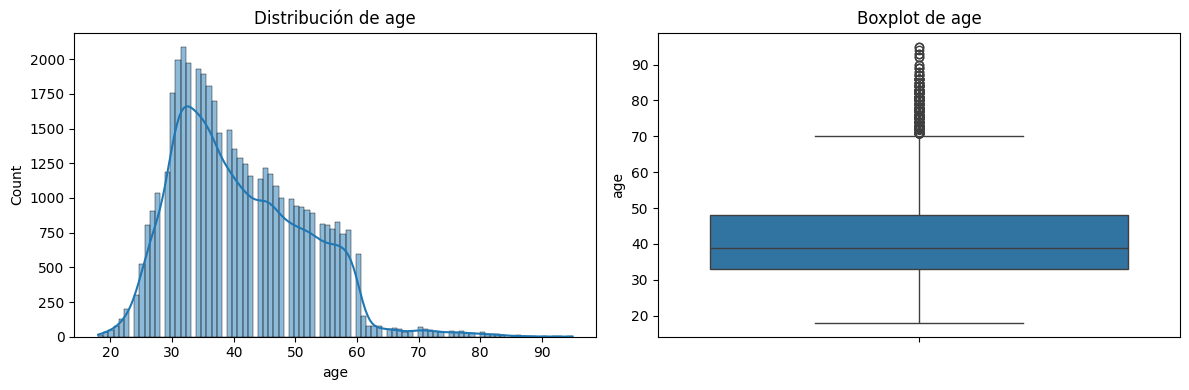

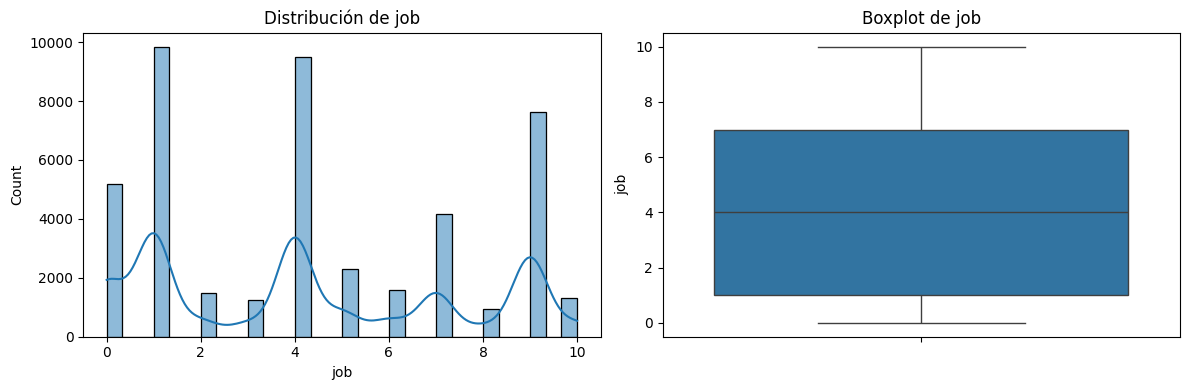

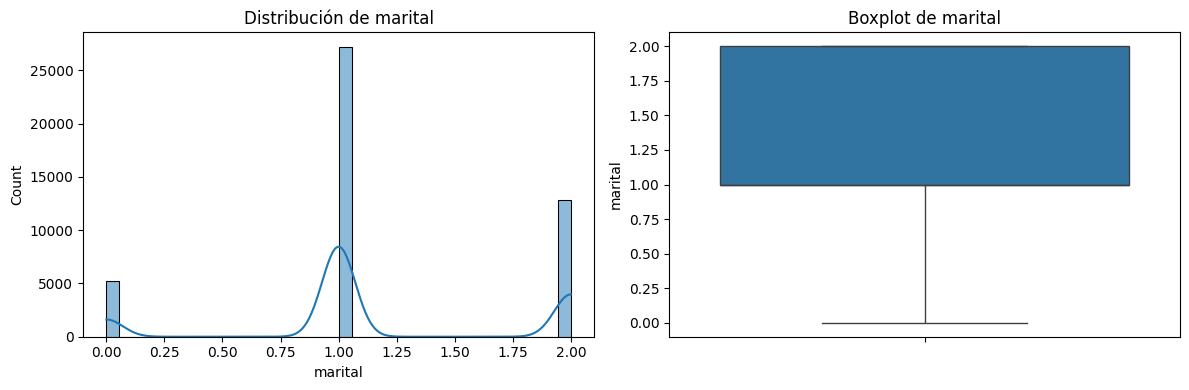

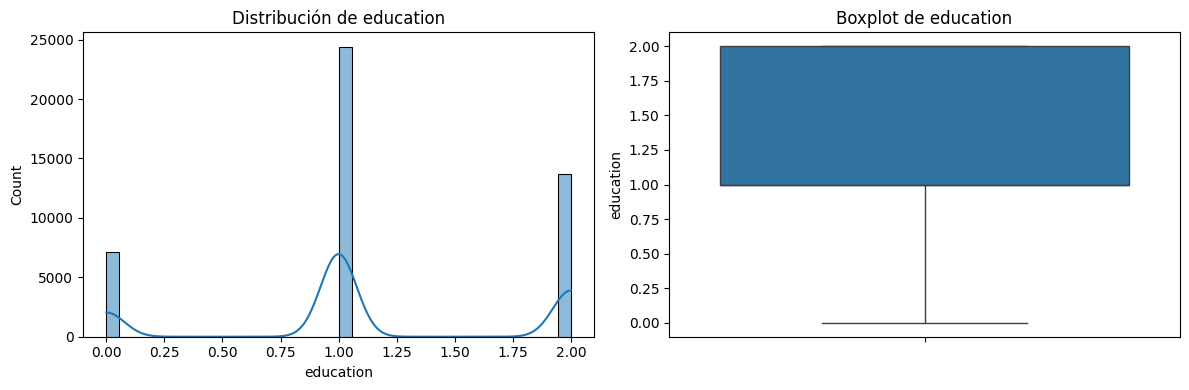

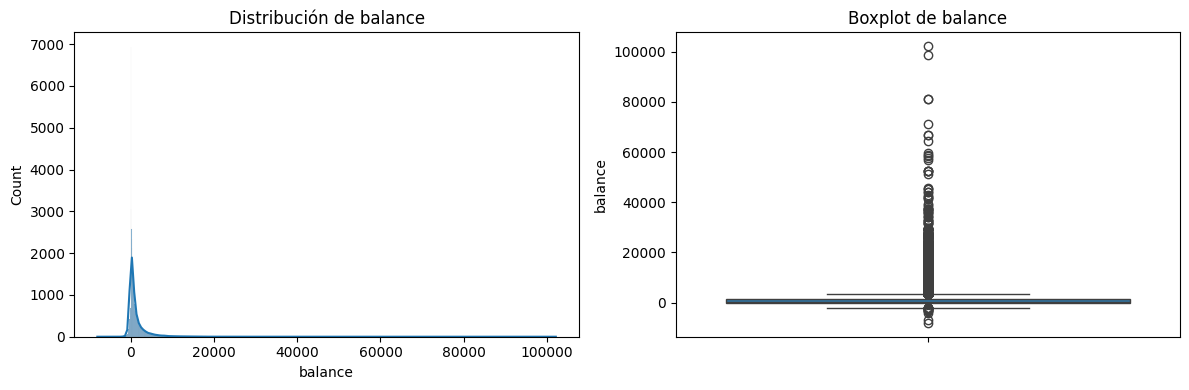

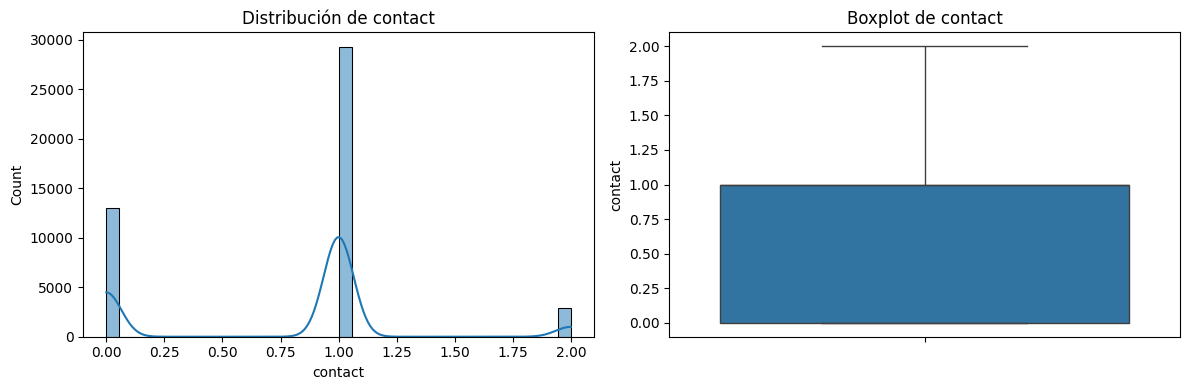

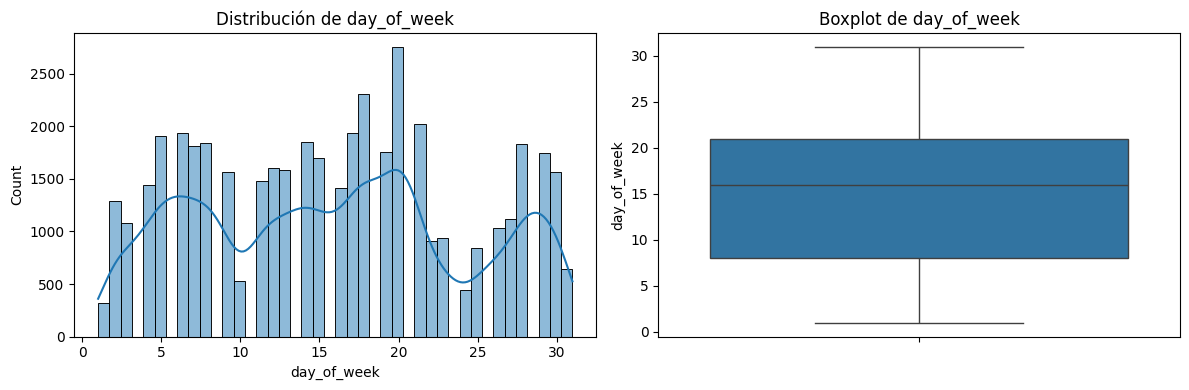

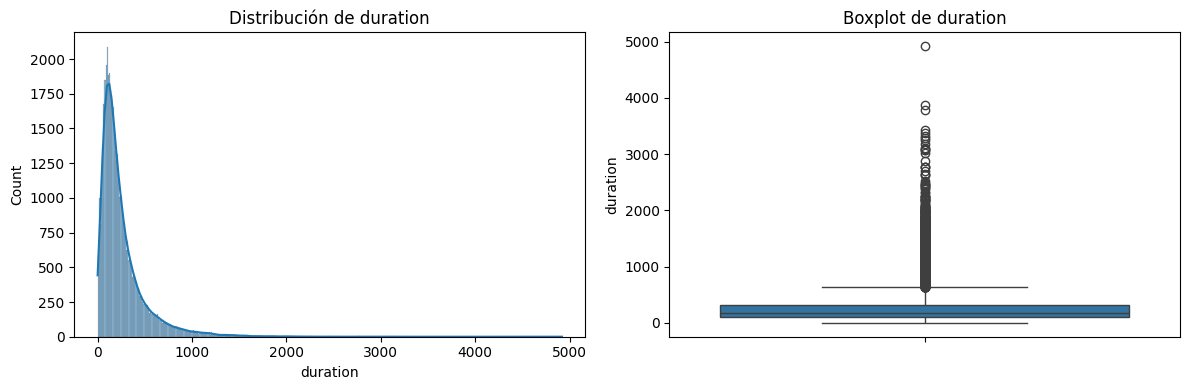

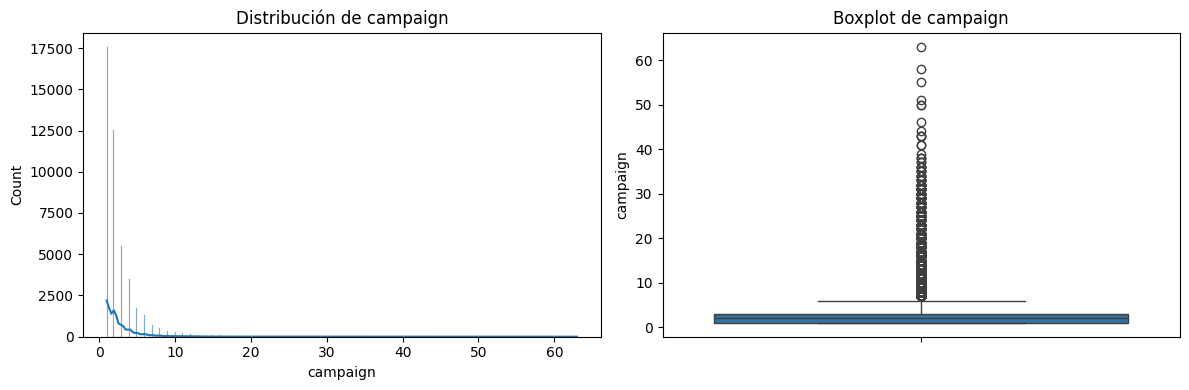

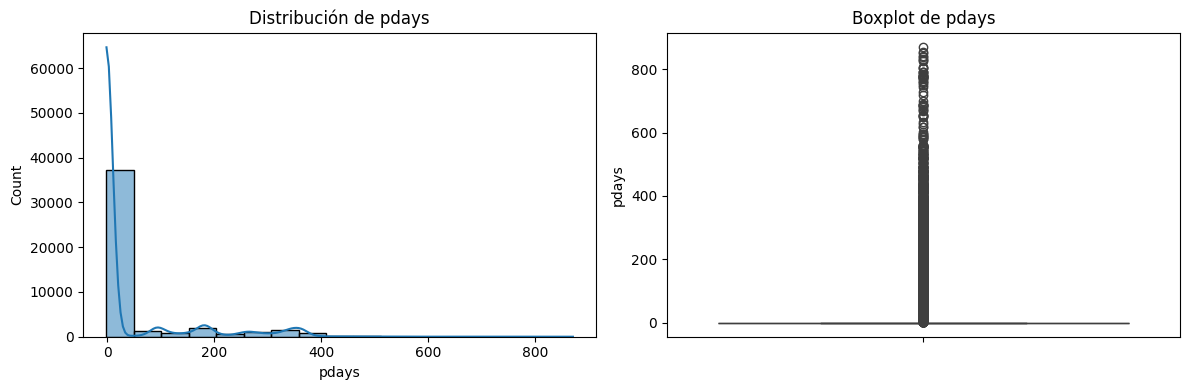

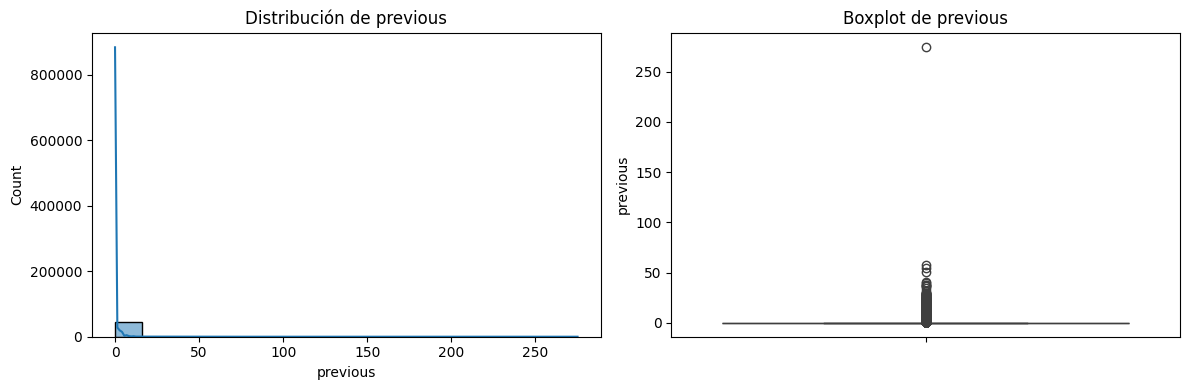

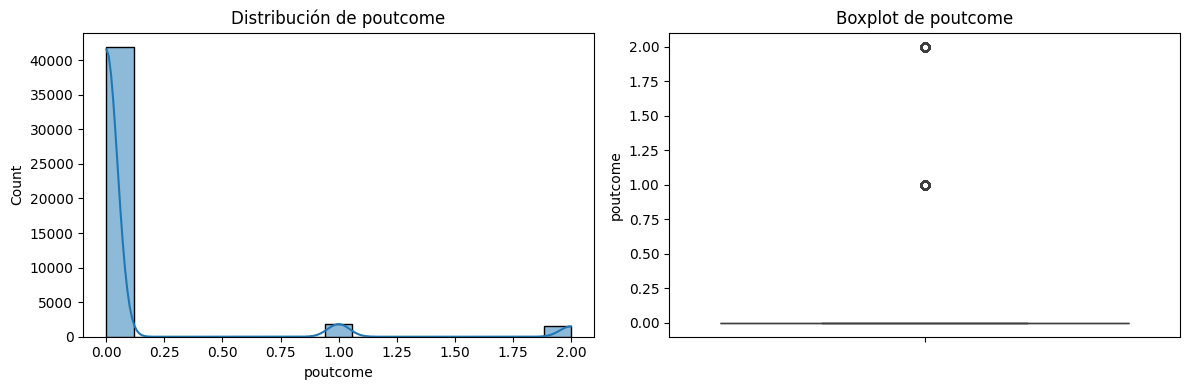

In [16]:
print("\n\n--- 2.1 Distribución de Variables Numéricas ---")

numeric_cols = X.select_dtypes(include=np.number).columns.tolist()

for col in numeric_cols:
    if col == 'default': continue
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(X[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.subplot(1, 2, 2)
    sns.boxplot(y=X[col])
    plt.title(f'Boxplot de {col}')
    plt.tight_layout()
    plt.show()

Del las distribuciones de las variables numericas se observa:

* La edad de los clientes se concentra fuertemente promediando los 30, pero con amplitud desde los 20 hasta los 60 incluse,

* En 3 trabajo predominan fuertemente 4 categorias  0, 1, 4 y 9: desconcido, de administracion, ama de casa y retirado (este ultimo se contradice con la variable anterior donde las personas en edad jubilatoria son superior al 65 años, a menos que la politica local tenga excepciones)

* *Marital* y *education* muestran similar distribucion en su segunda categoria Married y Secondary respectivamente

* El balance tiene una concentracion en valores bajos pero la existencia de valores extremos



--- 2. Distribución de Variables Categóricas ---


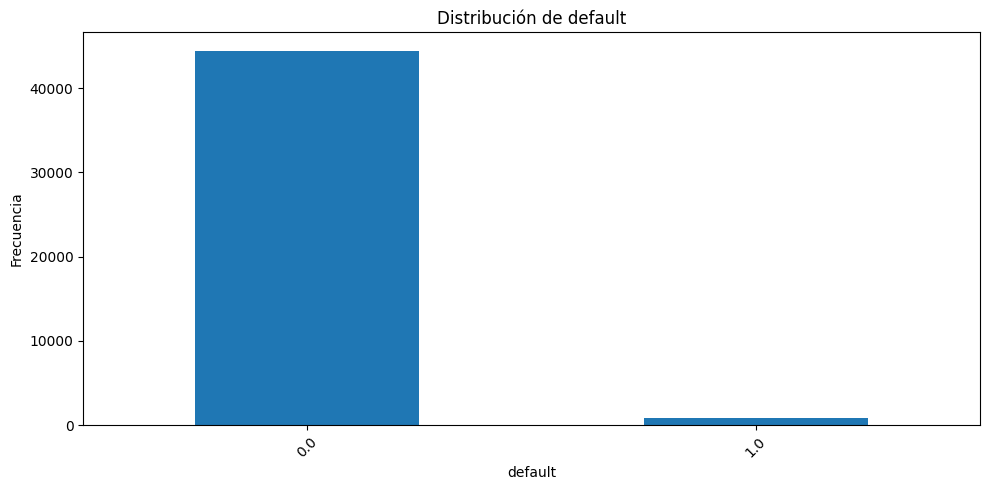


Conteos para default:
default
0.0    0.981973
1.0    0.018027
Name: proportion, dtype: float64


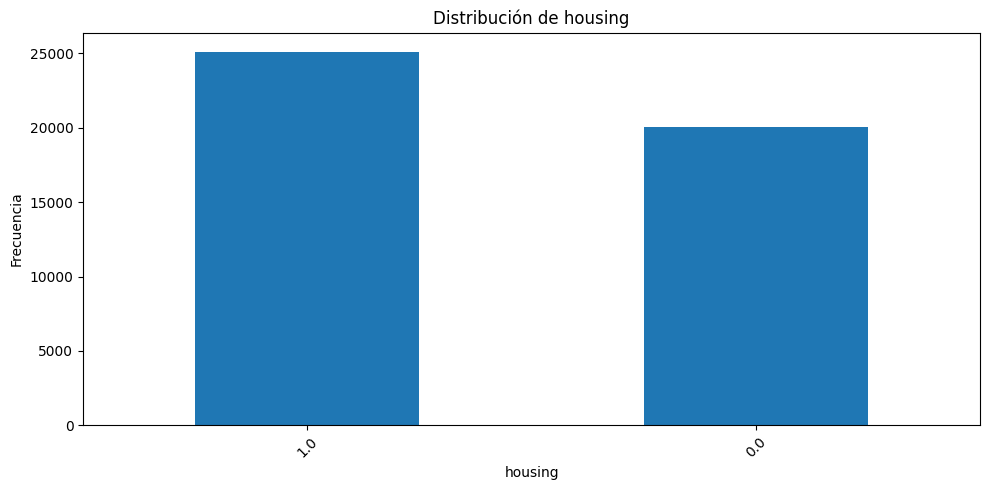


Conteos para housing:
housing
1.0    0.555838
0.0    0.444162
Name: proportion, dtype: float64


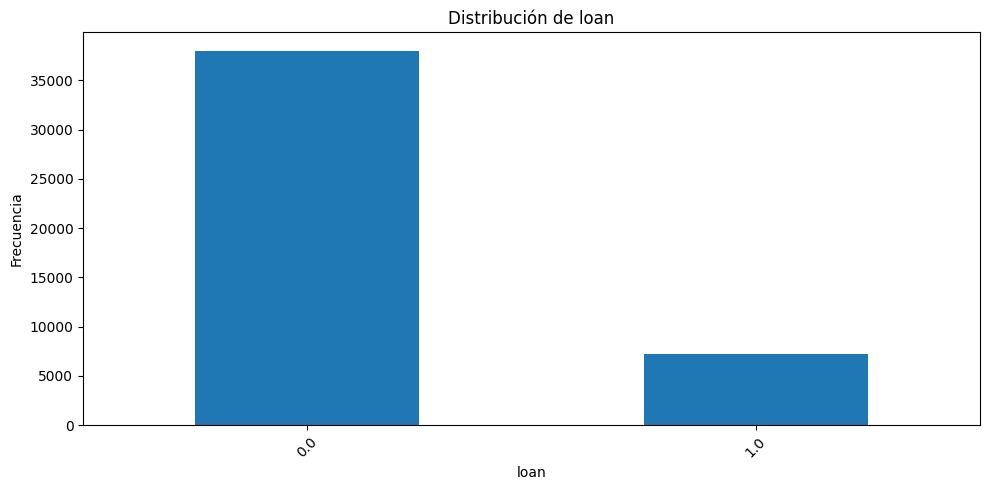


Conteos para loan:
loan
0.0    0.839774
1.0    0.160226
Name: proportion, dtype: float64


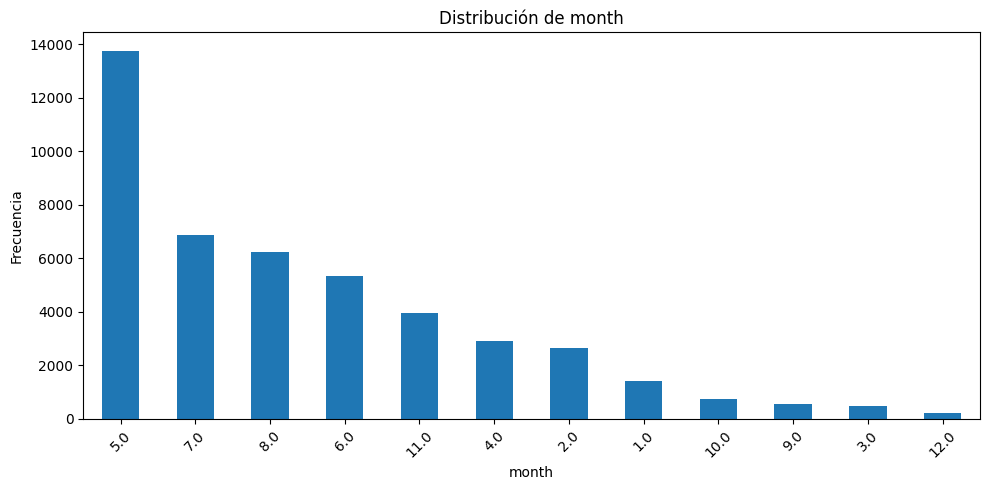


Conteos para month:
month
5.0     0.304483
7.0     0.152507
8.0     0.138174
6.0     0.118135
11.0    0.087810
4.0     0.064851
2.0     0.058592
1.0     0.031032
10.0    0.016323
9.0     0.012807
3.0     0.010551
12.0    0.004733
Name: proportion, dtype: float64


In [17]:
print("\n\n--- 2.2 Distribución de Variables Categóricas ---")
categorical_cols = X.select_dtypes(include='object').columns.tolist()
for col in categorical_cols:
    plt.figure(figsize=(10, 5))
    # Si la columna es float pero la tratamos como categórica, convertir a int para el conteo si tiene sentido
    if X[col].dtype == 'float64':
        X[col].fillna(-999).astype(int).value_counts().plot(kind='bar')
    else:
        X[col].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {col}')
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    print(f"\nConteos para {col}:\n{X[col].value_counts(normalize=True, dropna=False)}")

* los valores default corresponden al 1,8% del total de la base

* la cantidad de clientes con creditos hipotercarios es mejor a la cantidad de los que poseen un prestamos personal

* las campañas de marketing se realizan principalmente a medidados del año Mayo significativamente, julio, agosto y junio y en menor medida en las epocas invernales de la zona de los clientes (diciembre siendo el de menor medida)

## 2.2 Explorcion de default por categorias


--- 2.3 Scatterplots de perfil ---


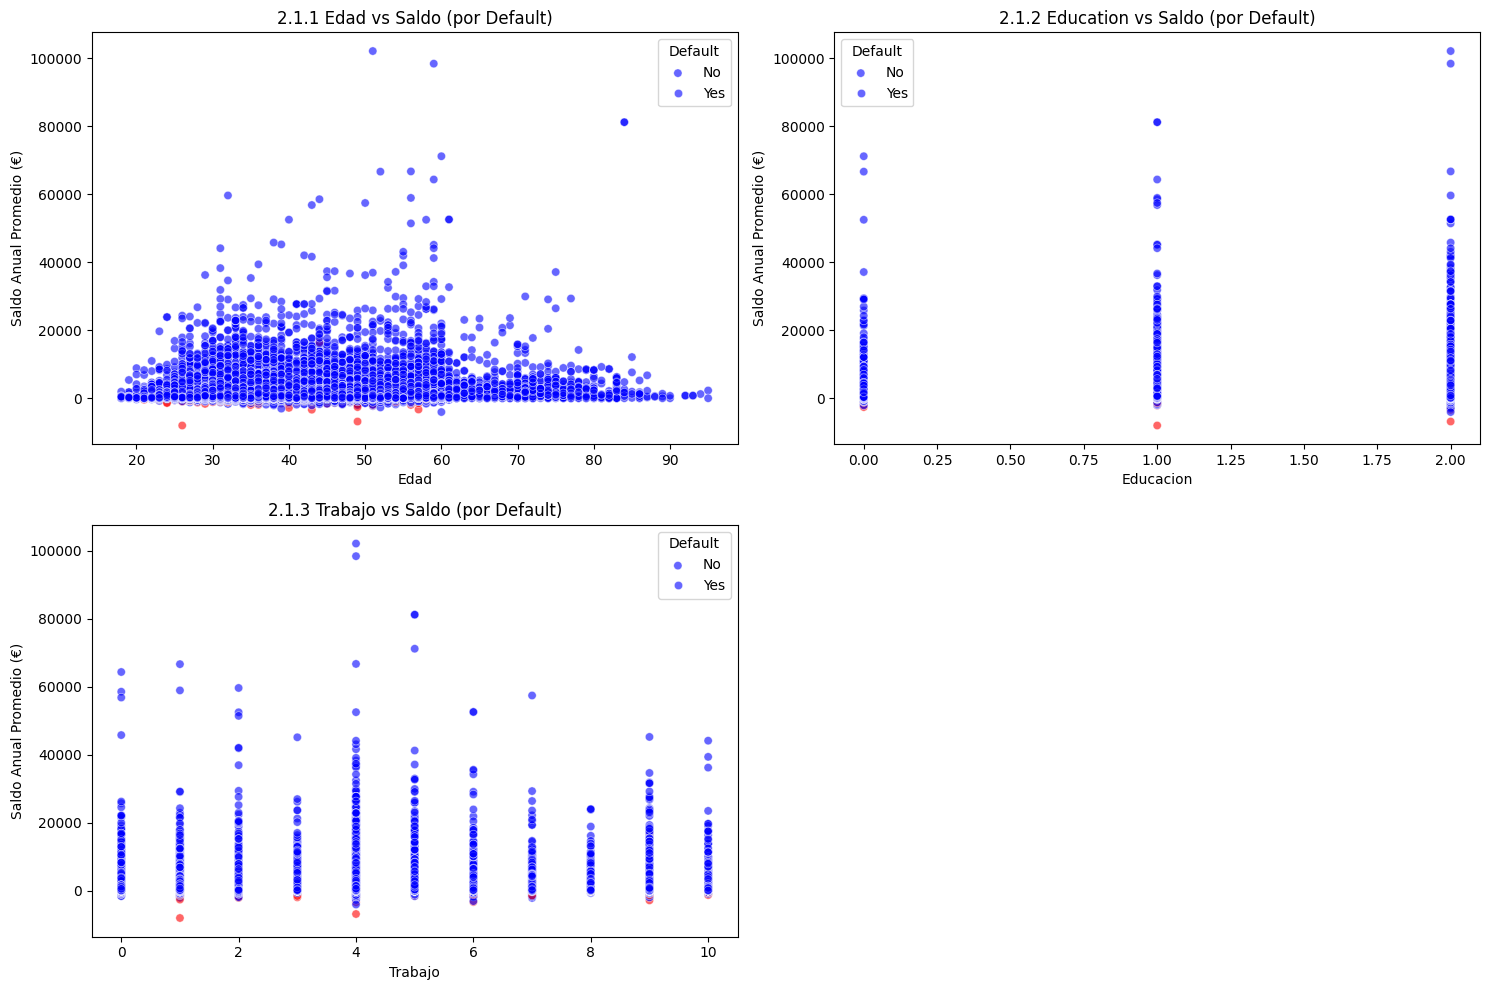

In [42]:
# 1. Scatterplots
print("\n--- 2.3 Scatterplots de perfil ---")
plt.figure(figsize=(15, 10))

# Scatterplot: age vs balance
plt.subplot(2, 2, 1)
sns.scatterplot(data=X, x='age', y='balance', hue='default', palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('2.1.1 Edad vs Saldo (por Default)')
plt.xlabel('Edad')
plt.ylabel('Saldo Anual Promedio (€)')
plt.legend(title='Default', labels=['No', 'Yes'])

# Scatterplot: balance vs duration
plt.subplot(2, 2, 2)
sns.scatterplot(data=X, x='education', y='balance', hue='default', palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('2.1.2 Education vs Saldo (por Default)')
plt.xlabel('Educacion')
plt.ylabel('Saldo Anual Promedio (€)')
plt.legend(title='Default', labels=['No', 'Yes'])

# Scatterplot: age vs duration
plt.subplot(2, 2, 3)
sns.scatterplot(data=X, x='job', y='balance', hue='default', palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title('2.1.3 Trabajo vs Saldo (por Default)')
plt.xlabel('Trabajo')
plt.ylabel('Saldo Anual Promedio (€)')
plt.legend(title='Default', labels=['No', 'Yes'])


plt.tight_layout()
plt.show()

* Se pueden visualizar la presencial de defaults por:
1. Niveles bajos de saldo
2. Existencia de default en edades entre 20 a 60, en las categorias de educacion y trabajo.

In [19]:
# Definir mapeos inversos
job_mapping = {
    0: 'unknown', 1: 'admin.', 2: 'unemployed', 3: 'management', 4: 'housemaid',
    5: 'entrepreneur', 6: 'student', 7: 'blue-collar', 8: 'self-employed',
    9: 'retired', 10: 'technician', 11: 'services'
}
education_mapping = {0: 'unknown', 1: 'secondary', 2: 'primary', 3: 'tertiary'}
marital_mapping = {0: 'married', 1: 'divorced', 2: 'single'}
# Función para crear mapeos inversos dinámicos
def create_category_mapping(col):
    if col in X_0.columns:
        # Obtener valores únicos, ordenados alfabéticamente (como OrdinalEncoder)
        unique_vals = sorted(X_0[col].dropna().unique())
        # Crear mapeo: 0 para 'unknown' o NaN, 1, 2, ... para otros valores
        mapping = {0: 'unknown'}
        for i, val in enumerate(unique_vals, 1):
            if val != 'unknown':
                mapping[i] = val
        return mapping
    return {}

# Crear mapeos inversos
job_mapping = create_category_mapping('job')
education_mapping = create_category_mapping('education')
marital_mapping = create_category_mapping('marital')


# Crear una copia de X para añadir columnas con etiquetas originales
X_plot = X.copy()
# Convertir a int para mapear correctamente
X_plot['job'] = X_plot['job'].astype(int)
X_plot['education'] = X_plot['education'].astype(int)
X_plot['marital'] = X_plot['marital'].astype(int)
# Mapear a etiquetas originales
X_plot['job_label'] = X_plot['job'].map(job_mapping)
X_plot['education_label'] = X_plot['education'].map(education_mapping)
X_plot['marital_label'] = X_plot['marital'].map(marital_mapping)



--- 2.3.1 Boxplots de perfil ---


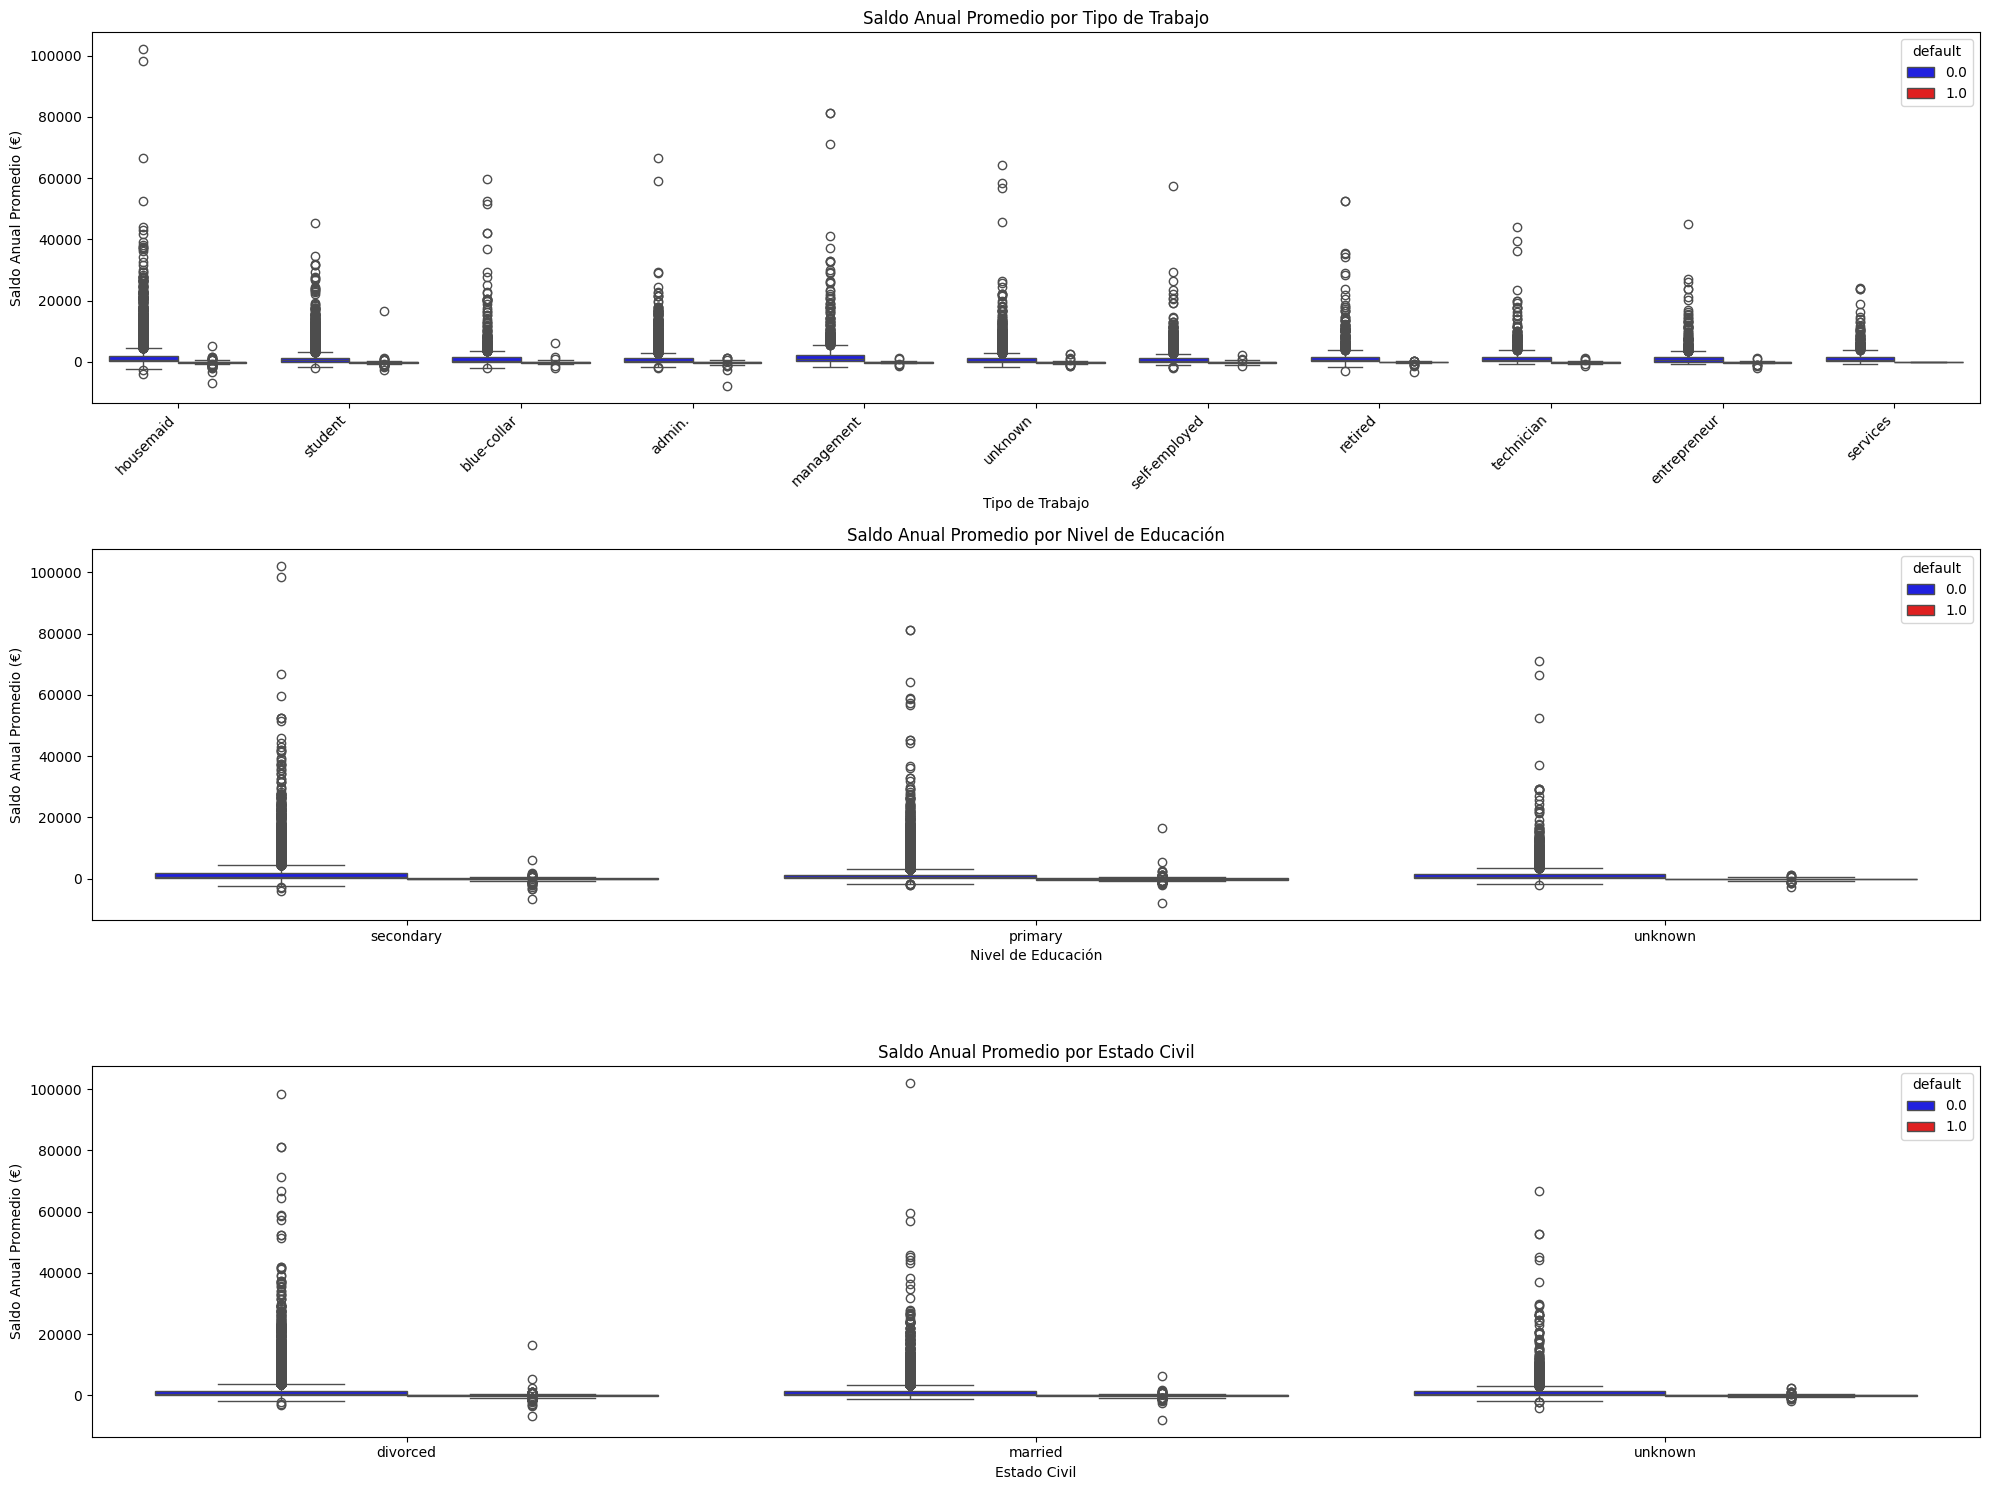

In [41]:
# Generar boxplots
print("\n--- 2.3.1 Boxplots de perfil ---")
plt.figure(figsize=(20, 15))

# Boxplot: balance por job
plt.subplot(3, 1, 1)
sns.boxplot(data=X_plot, x='job_label', y='balance', hue='default', palette={0: 'blue', 1: 'red'})
plt.title('Saldo Anual Promedio por Tipo de Trabajo')
plt.xlabel('Tipo de Trabajo')
plt.ylabel('Saldo Anual Promedio (€)')
plt.xticks(rotation=45, ha='right')

# Boxplot: balance por education
plt.subplot(3, 1, 2)
sns.boxplot(data=X_plot, x='education_label', y='balance', hue='default', palette={0: 'blue', 1: 'red'})
plt.title('Saldo Anual Promedio por Nivel de Educación')
plt.xlabel('Nivel de Educación')
plt.ylabel('Saldo Anual Promedio (€)')

# Boxplot: balance por marital
plt.subplot(3, 1, 3)
sns.boxplot(data=X_plot, x='marital_label', y='balance', hue='default', palette={0: 'blue', 1: 'red'})
plt.title('Saldo Anual Promedio por Estado Civil')
plt.xlabel('Estado Civil')
plt.ylabel('Saldo Anual Promedio (€)')

plt.tight_layout()
plt.show()

* el importe del saldo anual representa el princpal determinador del se visualiza que es consistentemente muy bajo (cercano a cero) para los clientes que incurren en default, independientemente de su tipo de trabajo, nivel de educación o estado civil

## 2.3 Correlacion de default con la tenencia de deuda

In [21]:
columnas = ['default', 'loan', 'housing']
#X_imputed[X_imputed['default'] == 1][columnas]

df_estatus = X[columnas]


--- 2.4.1 Plot de Conteo de Defaults por Estado de Préstamo e Hipoteca ---


<Figure size 1000x700 with 0 Axes>

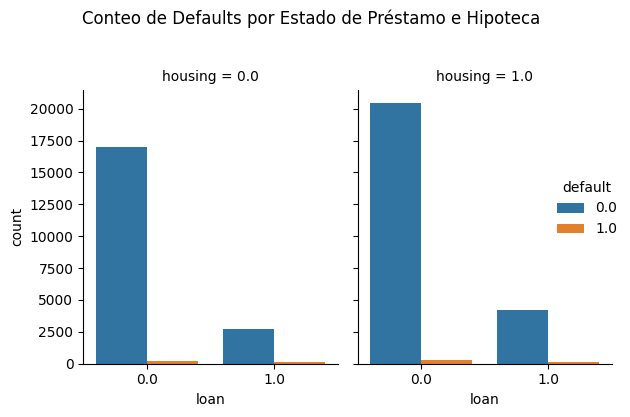

In [43]:
print("\n--- 2.4 Plot de Conteo de Defaults por Estado de Préstamo e Hipoteca ---")
plot_data_counts = df_estatus.groupby(['loan', 'housing', 'default']).size().reset_index(name='count')
plt.figure(figsize=(10, 7))
sns.catplot(x='loan', y='count', hue='default', col='housing', data=plot_data_counts, kind='bar', height=4, aspect=.7);
plt.suptitle('Conteo de Defaults por Estado de Préstamo e Hipoteca', y=1.03) # y=1.03 para que el título no se superponga
plt.tight_layout()
plt.show()


--- 2.4.2 Violin de Conteo de Defaults por Estado de Préstamo ---


<ipython-input-44-24cc3155294a>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_estatus, x='loan', y='default', inner='box', palette='Dark2')


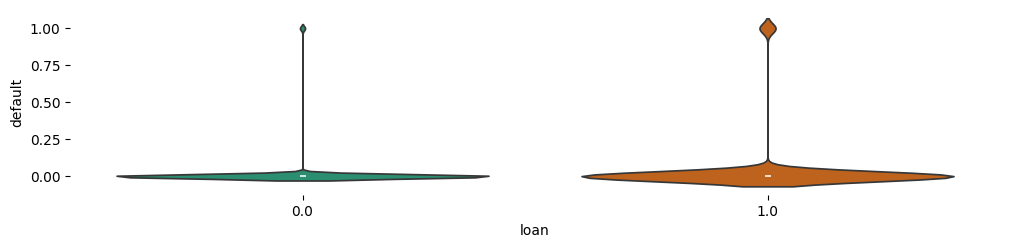

In [44]:
print("\n--- 2.4.1 Violin de Conteo de Defaults por Estado de Préstamo ---")
figsize = (12, 1.2 * len(df_estatus['default'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_estatus, x='loan', y='default', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)


--- 2.4.3 Violin de Conteo de Defaults por Estado de Hipoteca ---


<ipython-input-45-48eddc5d9511>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(df_estatus, x='housing', y='default', inner='box', palette='Dark2')


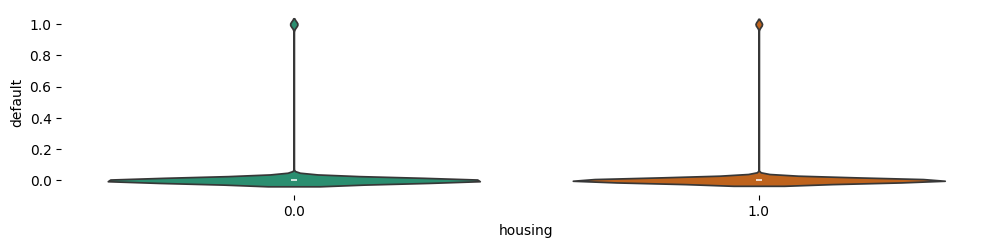

In [45]:
print("\n--- 2.4.2 Violin de Conteo de Defaults por Estado de Hipoteca ---")
figsize = (12, 1.2 * len(df_estatus['default'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_estatus, x='housing', y='default', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [46]:
print("\n--- 2.4.3 Correlacion de Defaults por Estado de Hipoteca ---")

df_estatus.corr()


--- 2.4.3 Correlacion de Defaults por Estado de Hipoteca ---


,default,loan,housing
default,1.000000,0.077234,-0.006025
loan,0.077234,1.000000,0.041323
housing,-0.006025,0.041323,1.000000


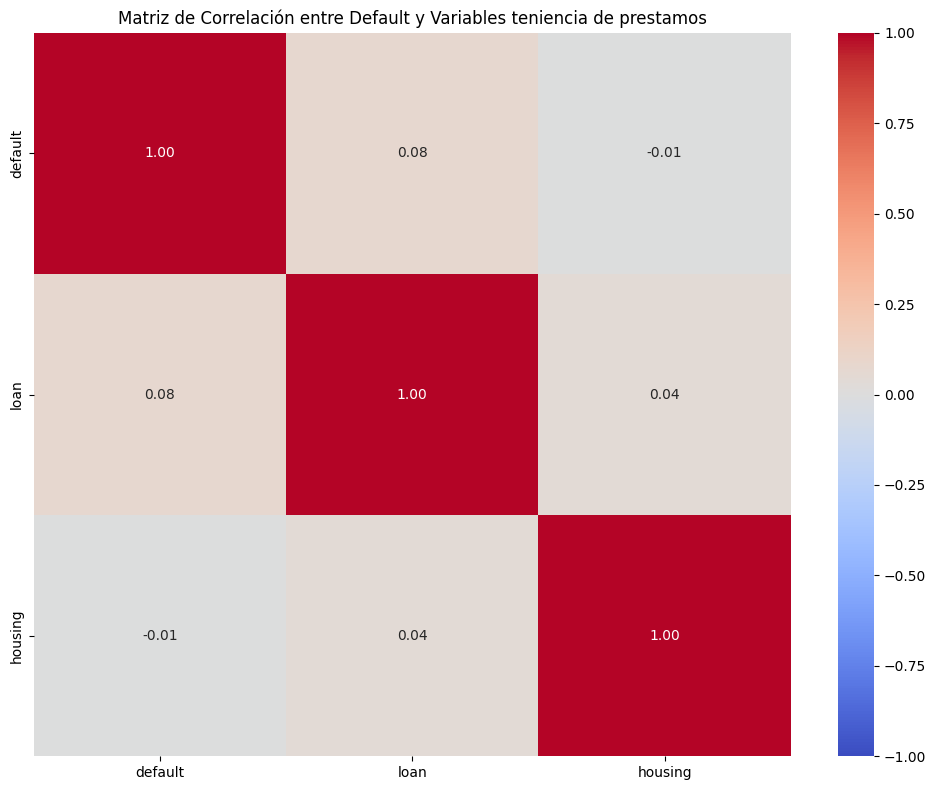

In [26]:
    correlation_matrix_marcas = df_estatus.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_marcas, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Matriz de Correlación entre Default y Variables teniencia de prestamos')
    plt.tight_layout()
    plt.show()

* De la visualizacion se observa que la correlación de 0.08 entre default y loan sugiere una tendencia positiva mínima: tener un préstamo (loan=1) se asocia muy ligeramente con una mayor probabilidad de default. Sin embargo, la fuerza de esta asociación es tan baja que loan por sí solo no parece ser un indicador lineal fuerte de default, y

* La correlación de -0.01 entre default y housing es prácticamente nula, lo que indica que no hay una relación lineal apreciable entre tener un préstamo hipotecario y la probabilidad de default.

Estas bajas correlaciones sugieren que, individualmente y de forma lineal, ni loan ni housing son factores fuertemente predictivos del default.

## 2.4 Correlaciones con default

Modelo inicial: Armado de pesos de correlacion para estimar default



In [48]:
print("2.5 Correlacion de las variables del set de datos")
X.corr()

2.5 Correlacion de las variables del set de datos


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
age,1.000000,-0.031380,-0.403240,-0.169249,-0.017879,0.097783,-0.185513,-0.015655,0.092577,-0.009120,0.092903,-0.004648,0.004760,-0.023758,0.001288,0.020402
job,-0.031380,1.000000,0.063329,0.187550,-0.006029,0.017310,-0.113292,-0.027639,0.067508,0.025225,0.042004,0.006821,0.004003,-0.021542,0.001070,0.024288
marital,-0.403240,0.063329,1.000000,0.120962,-0.007023,0.002122,-0.016096,-0.046893,0.018282,-0.005261,-0.050938,0.011852,-0.008994,0.019172,0.014973,0.030059
education,-0.169249,0.187550,0.120962,1.000000,-0.011853,0.068668,-0.074129,-0.023863,0.077930,0.026565,0.070266,0.003068,0.002223,0.006682,0.027142,0.051939
default,-0.017879,-0.006029,-0.007023,-0.011853,1.000000,-0.066745,-0.006025,0.077234,-0.024095,0.009424,0.014989,-0.010021,0.016822,-0.029979,-0.018329,-0.027870
balance,0.097783,0.017310,0.002122,0.068668,-0.066745,1.000000,-0.068768,-0.084350,0.047701,0.004503,0.094605,0.021560,-0.014578,0.003435,0.016674,0.035540
housing,-0.185513,-0.113292,-0.016096,-0.074129,-0.006025,-0.068768,1.000000,0.041323,-0.207722,-0.027982,-0.173887,0.005075,-0.023599,0.124178,0.037076,-0.061944
loan,-0.015655,-0.027639,-0.046893,-0.023863,0.077234,-0.084350,0.041323,1.000000,0.000058,0.011370,0.021638,-0.012412,0.009980,-0.022754,-0.011043,-0.052306
contact,0.092577,0.067508,0.018282,0.077930,-0.024095,0.047701,-0.207722,0.000058,1.000000,0.038643,0.167103,0.001494,0.020046,0.210651,0.139518,0.143651
day_of_week,-0.009120,0.025225,-0.005261,0.026565,0.009424,0.004503,-0.027982,0.011370,0.038643,1.000000,0.101989,-0.030206,0.162490,-0.093044,-0.051710,-0.043147


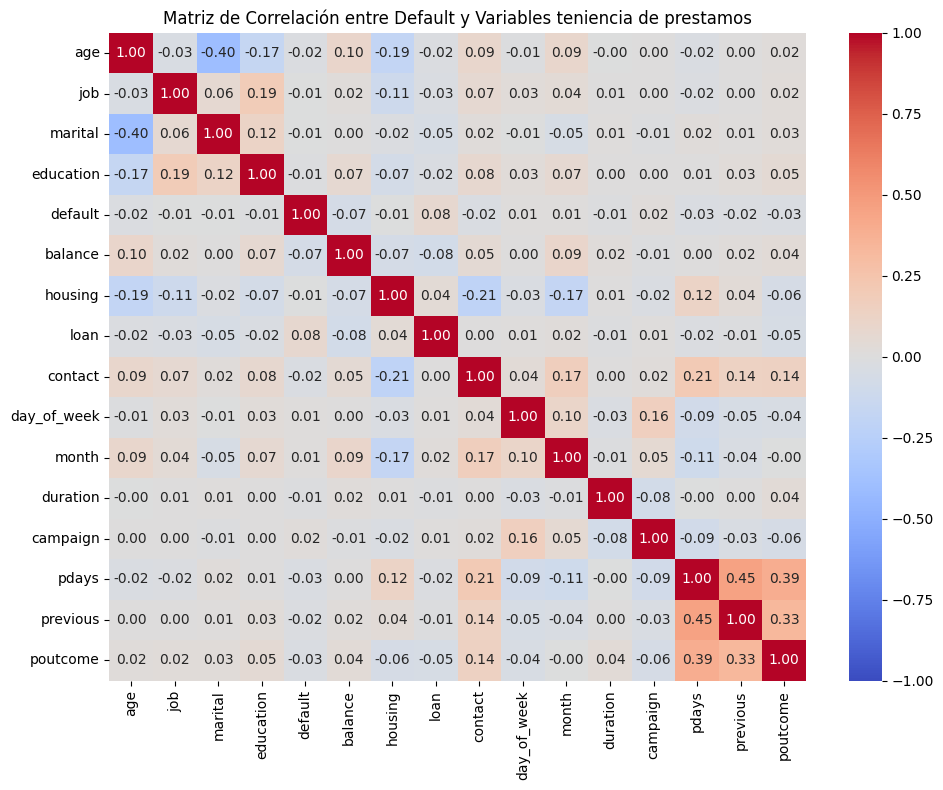

In [28]:
    correlation_matrix_marcas = X.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix_marcas, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Matriz de Correlación entre Default y Variables teniencia de prestamos')
    plt.tight_layout()
    plt.show()

* default no posee correlaciones signficativas dado su bajo nivel de ocurrencia, siendo el más resaltado *loan* pero con una correlacion muy  baja del 8%

# 3- Modelo de prediccion de default con randomforest

Modelo propuesto por el Banco para evaluar el default en su modulo de marketing.

Para ello se reprocesa:
0. Asegurar que 'default' sea de tipo numérico

1. Correlaciones con default (Todas las variables predictoras)

    1. Se transfiere como float todas las variables

2. Inicio de Random Forest

3. Verificación de datos de entrenamiento

4. Visualizar la distribución de defaults PREDICHOS vs. REALES

    1. Matriz de Confusión  

    2. Curva ROC y AUC  

5. Calcular la tasa de default para cada combinación  de prestamos *loan, housing*



## 3.1 Inicio de Random Forest

In [37]:
#0. Asegurar que 'default' sea de tipo numérico.
print("\n--- 3.0. Asegurar que 'default' sea de tipo numérico ---")

X['default'] = X['default'].astype('int64')

# 1. Correlación con default
# Seleccionar todas las columnas EXCEPTO 'default' para la correlación
predictor_cols_for_corr = [col for col in X.columns if col != 'default']
print("\n--- 3.1 Correlaciones con default (Todas las variables predictoras) ---")
correlations = X[predictor_cols_for_corr + ['default']].corr(method='spearman')['default'].drop('default')
correlations.sort_values(ascending=False)

print("\n--- 3.1.1 Se transfiere como float todas las variables---")

X = X.astype(float) # se transfiere como float todas las variables

# 2. Random Forest usando TODAS las columnas predictoras

print("\n--- 3.2 Inicio de Random Forest ---")

# Preparar datos para el modelo
X_features = X.drop('default', axis=1)
y_target = X['default']

X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.3, random_state=42, stratify=y_target # stratify es bueno para clases desbalanceadas
) #entrenamiento con el 30% de la muestra

print("\n--- 3.3 Verificación de datos de entrenamiento ---") # Verificar que X_train no esté vacío y tenga las columnas correctas
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced') # class_weight puede ayudar con desbalance
rf.fit(X_train, y_train)

# Obtener importancia de las variables
importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print("\n--- Importancia de las variables (Random Forest - Todas las columnas) ---")
print(importances)



--- 3.0. Asegurar que 'default' sea de tipo numérico ---

--- 3.1 Correlaciones con default (Todas las variables predictoras) ---

--- 3.1.1 Se transfiere como float todas las variables---

--- 3.2 Inicio de Random Forest ---

--- 3.3 Verificación de datos de entrenamiento ---

--- Importancia de las variables (Random Forest - Todas las columnas) ---
balance        0.447726
duration       0.102172
age            0.090512
day_of_week    0.073913
job            0.048019
campaign       0.045506
month          0.041847
loan           0.036977
marital        0.023550
education      0.020792
pdays          0.020403
contact        0.015886
housing        0.014054
previous       0.013732
poutcome       0.004910
dtype: float64


Del proceso realizado se obtuvo:
* El balance es la variable más importante para al predecir el default. Esto sugiere que el saldo en la cuenta del cliente es el factor individual más determinante que el modelo utiliza para diferenciar entre quienes entran en default y quienes no.

* duration (Duración del último contacto, Importancia: 0.1017): La duración de la interacción más reciente tiene un peso considerable, indicando que la naturaleza o el resultado de esta llamada/contacto es relevante.

* age (Edad, Importancia: 0.0858): La edad del c Cliente también juega un papel significativo.

* day_of_week (Día de la semana del último contacto, Importancia: 0.0756): El momento específico del contacto dentro de la semana también es utilizado por el modelo.

Conclusion del proceso: El análisis del modelo Random Forest identifica el balance de la cuenta como el factor más crítico asociado al default, La importancia de duration, day_of_week y month sugiere que las características y el momento de las interacciones recientes con el cliente son relevantes.

## 3.2 Analisis de las predicciones


--- Obtener Predicciones del Modelo ---

--- 3.4 Visualizar la distribución de defaults PREDICHOS vs. REALES ---


<ipython-input-38-89858ef0ff85>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_test, ax=ax[0], palette=['skyblue', 'lightcoral'])
<ipython-input-38-89858ef0ff85>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(['No Default (0)', 'Default (1)'])
<ipython-input-38-89858ef0ff85>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_pred, ax=ax[1], palette=['skyblue', 'lightcoral'])
<ipython-input-38-89858ef0ff85>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(['No Defau

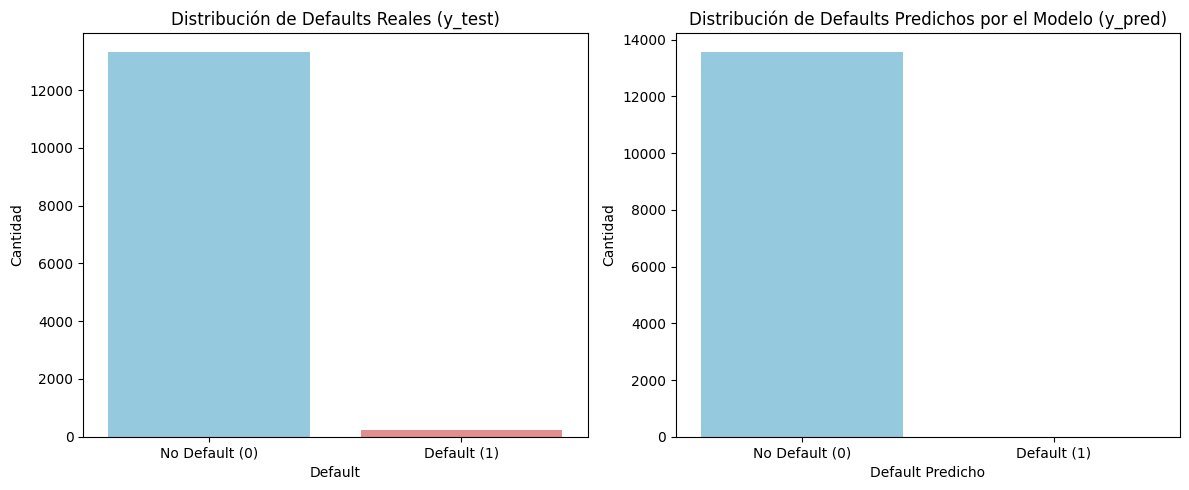

In [38]:
print("\n--- Obtener Predicciones del Modelo ---")
y_pred = rf.predict(X_test)
y_pred_proba = rf.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva (default=1)

print("\n--- 3.4 Visualizar la distribución de defaults PREDICHOS vs. REALES ---")
# --- 1. Visualizar la distribución de defaults PREDICHOS vs. REALES ---
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_test, ax=ax[0], palette=['skyblue', 'lightcoral'])
ax[0].set_title('Distribución de Defaults Reales (y_test)')
ax[0].set_xlabel('Default')
ax[0].set_ylabel('Cantidad')
ax[0].set_xticklabels(['No Default (0)', 'Default (1)'])

sns.countplot(x=y_pred, ax=ax[1], palette=['skyblue', 'lightcoral'])
ax[1].set_title('Distribución de Defaults Predichos por el Modelo (y_pred)')
ax[1].set_xlabel('Default Predicho')
ax[1].set_ylabel('Cantidad')
ax[1].set_xticklabels(['No Default (0)', 'Default (1)'])
plt.tight_layout()
plt.show()


3.4.1 Matriz de Confusión  :


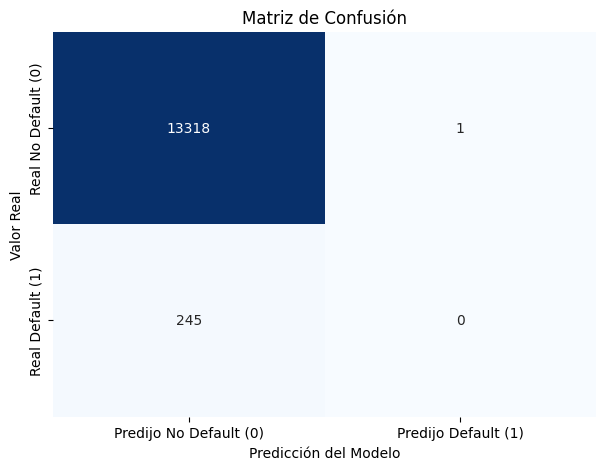


Informe de Clasificación:
                precision    recall  f1-score   support

No Default (0)       0.98      1.00      0.99     13319
   Default (1)       0.00      0.00      0.00       245

      accuracy                           0.98     13564
     macro avg       0.49      0.50      0.50     13564
  weighted avg       0.96      0.98      0.97     13564



In [39]:
print("\n3.4.1 Matriz de Confusión  :")

# --- 2. Matriz de Confusión ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predijo No Default (0)', 'Predijo Default (1)'],
            yticklabels=['Real No Default (0)', 'Real Default (1)'])
plt.xlabel('Predicción del Modelo')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()

print("\nInforme de Clasificación:")
#class_report_dict = classification_report(y_test, y_pred, output_dict=True)
print(classification_report(y_test, y_pred, target_names=['No Default (0)', 'Default (1)']))



3.4.2 Curva ROC y AUC  :


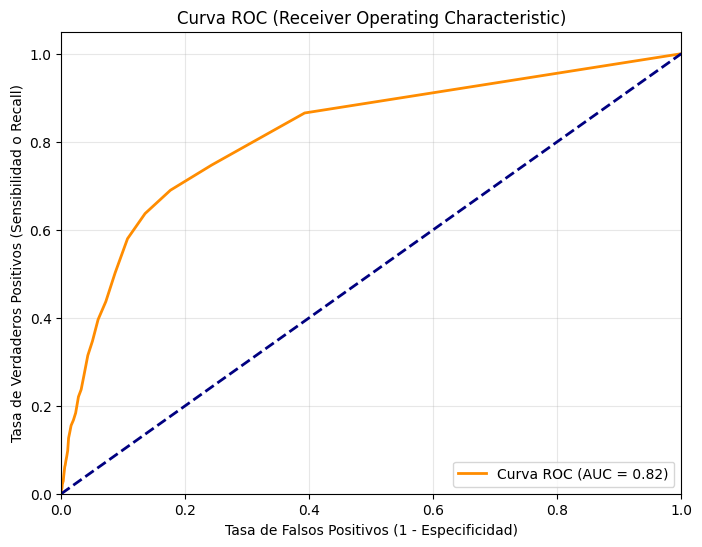


Área Bajo la Curva ROC (AUC): 0.8158


In [40]:
print("\n3.4.2 Curva ROC y AUC  :")

# --- 3. Curva ROC y AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad o Recall)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

print(f"\nÁrea Bajo la Curva ROC (AUC): {roc_auc:.4f}")


> De estos resultados, se observa que el modelo tiene un rendimiento excelente para la clase "No Default", con casi perfecta precisión y recall.
Sin embargo, falla en la clase "Default", con 0 precision, 0 recall y 0 f1-score. Esto indica que el modelo no detectó ningún caso de default, clasificando todos los 245 casos reales de default como "No Default"


## 3.3 Análisis con estados de prestamos


3.5.1 Calcular la tasa de default para cada combinación  :


<Figure size 1000x700 with 0 Axes>

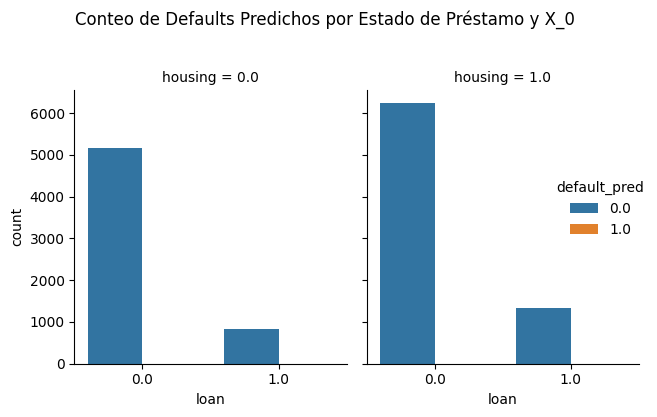

In [36]:
df_viz = pd.DataFrame({
    'loan': X_test['loan'],
    'housing': X_test['housing'],
    'default_pred': y_pred
})
print("\n3.5.1 Calcular la tasa de default para cada combinación  :")
plot_data_counts = df_viz.groupby(['loan', 'housing', 'default_pred']).size().unstack(fill_value=0)

plot_data_counts = df_viz.groupby(['loan', 'housing', 'default_pred']).size().reset_index(name='count')

plt.figure(figsize=(10, 7))
sns.catplot(x='loan', y='count', hue='default_pred', col='housing', data=plot_data_counts, kind='bar', height=4, aspect=.7);

plt.suptitle('Conteo de Defaults Predichos por Estado de Préstamo y X_0', y=1.03) # y=1.03 para que el título no se superponga
plt.tight_layout()
plt.show()

# 4- Otros Modelos de boosting aplicando SMOTE

El objetivo de SMOTE es crear ejemplos sintéticos de la clase minoritaria (en este caso, default=1) para que el modelo tenga más instancias de esta clase durante el entrenamiento, ayudándole a aprender mejor sus características.

Por ello se procedió a:

1. Separar features (X_features) y target (y_target)

2. Dividir en Conjuntos de Entrenamiento y Prueba

3. Aplicar SMOTE al conjunto de entrenamiento

4. Entrenar y Evaluar Modelos: Matriz de Confusió, Informe de Clasificación
y Curva abajo de ROC.

    1.Random Forest

    2.XGBoost
    
    3.LightGBM

5. Comparación Gráfica de Curvas ROC


## 4.1 Inicio de los modelos

In [51]:
print("\n--- 4.1 Separar features (X_features) y target (y_target)--")
X_features = X.drop('default', axis=1)
y_target = X['default']

print("\n--- 4.2 Dividir en Conjuntos de Entrenamiento y Prueba---")

#  Dividir en Conjuntos de Entrenamiento y Prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target, test_size=0.3, random_state=42, stratify=y_target
)
print(f"\nForma de X_train: {X_train.shape}, Forma de y_train: {y_train.shape}")
print(f"Forma de X_test: {X_test.shape}, Forma de y_test: {y_test.shape}")
print(f"Distribución de 'default' en y_train antes de SMOTE:\n{y_train.value_counts(normalize=True)}")



Separar features (X_features) y target (y_target)

Forma de X_train: (31647, 15), Forma de y_train: (31647,)
Forma de X_test: (13564, 15), Forma de y_test: (13564,)
Distribución de 'default' en y_train antes de SMOTE:
default
0.0    0.981989
1.0    0.018011
Name: proportion, dtype: float64


In [52]:
# --- Aplicar SMOTE al Conjunto de Entrenamiento ---
smote = SMOTE(random_state=42)
print("---\n 4.3 Aplicando SMOTE al conjunto de entrenamiento:")
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"Forma de X_train después de SMOTE: {X_train_smote.shape}")
print(f"Distribución de 'default' en y_train después de SMOTE:\n{y_train_smote.value_counts(normalize=True)}")


Aplicando SMOTE al conjunto de entrenamiento...
Forma de X_train después de SMOTE: (62154, 15)
Distribución de 'default' en y_train después de SMOTE:
default
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


## 4.2 Resultados de las predicciones


--- Entrenando y Evaluando: Random Forest (con SMOTE) ---

Matriz de Confusión:


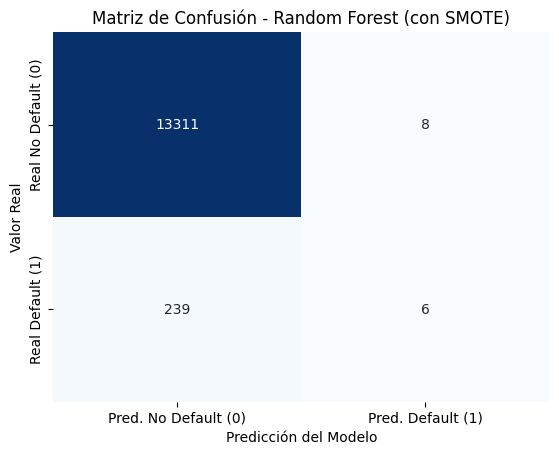


Informe de Clasificación:
                precision    recall  f1-score   support

No Default (0)       0.98      1.00      0.99     13319
   Default (1)       0.43      0.02      0.05       245

      accuracy                           0.98     13564
     macro avg       0.71      0.51      0.52     13564
  weighted avg       0.97      0.98      0.97     13564

Área Bajo la Curva ROC (AUC-ROC): 0.8184

--- Visualizando relaciones para: Random Forest (con SMOTE) ---


<Figure size 1000x700 with 0 Axes>

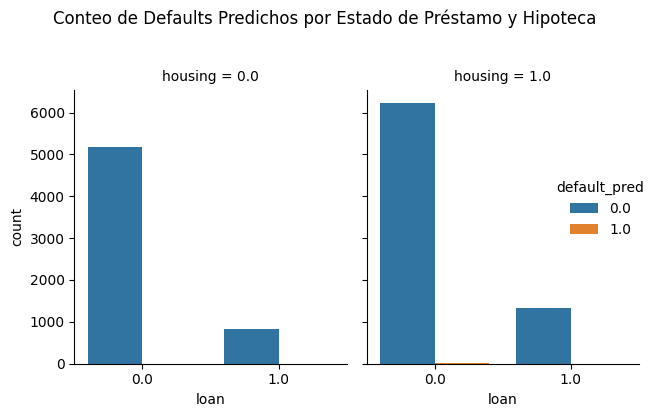


--- Entrenando y Evaluando: XGBoost (con SMOTE) ---


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:23:36] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Matriz de Confusión:


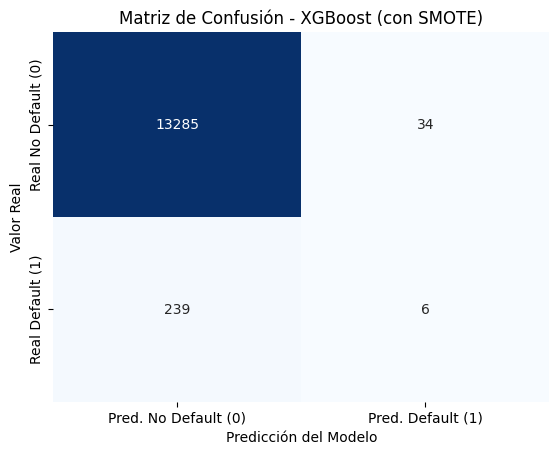


Informe de Clasificación:
                precision    recall  f1-score   support

No Default (0)       0.98      1.00      0.99     13319
   Default (1)       0.15      0.02      0.04       245

      accuracy                           0.98     13564
     macro avg       0.57      0.51      0.52     13564
  weighted avg       0.97      0.98      0.97     13564

Área Bajo la Curva ROC (AUC-ROC): 0.8445

--- Visualizando relaciones para: XGBoost (con SMOTE) ---


<Figure size 1000x700 with 0 Axes>

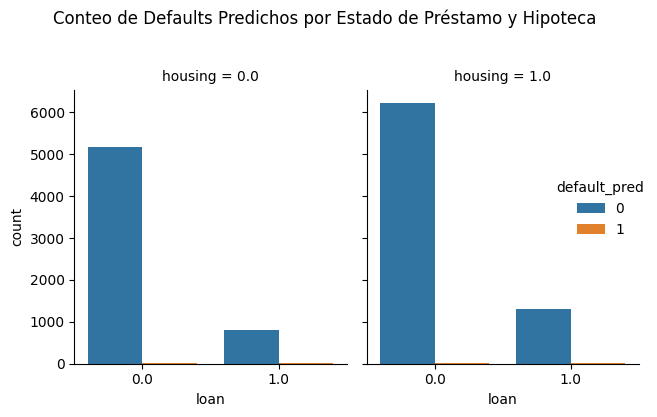


--- Entrenando y Evaluando: LightGBM (con SMOTE) ---
[LightGBM] [Info] Number of positive: 31077, number of negative: 31077
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3824
[LightGBM] [Info] Number of data points in the train set: 62154, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

Matriz de Confusión:


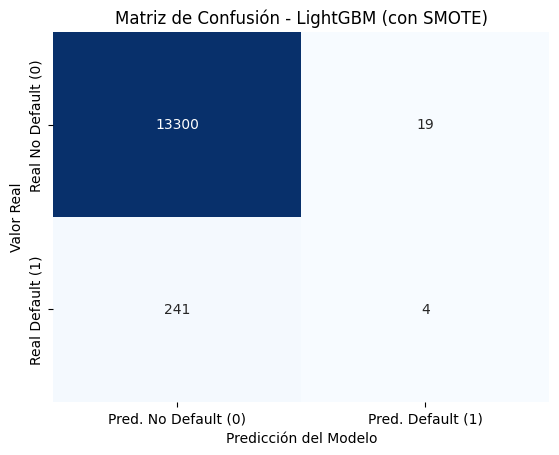


Informe de Clasificación:
                precision    recall  f1-score   support

No Default (0)       0.98      1.00      0.99     13319
   Default (1)       0.17      0.02      0.03       245

      accuracy                           0.98     13564
     macro avg       0.58      0.51      0.51     13564
  weighted avg       0.97      0.98      0.97     13564

Área Bajo la Curva ROC (AUC-ROC): 0.8528

--- Visualizando relaciones para: LightGBM (con SMOTE) ---


<Figure size 1000x700 with 0 Axes>

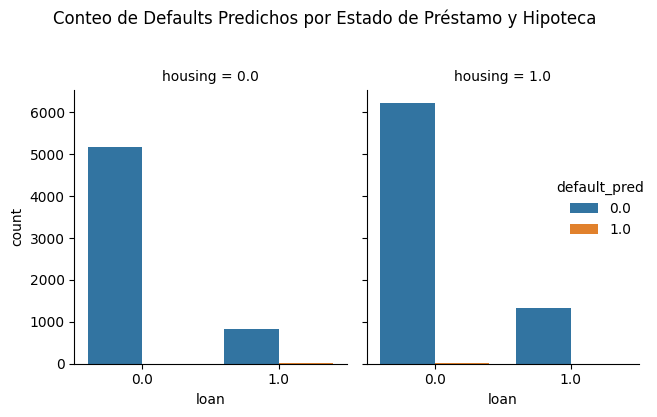

In [53]:
print("\n--- 4.4 Entrenar y Evaluar Modelos ---")

models = {
    "Random Forest (con SMOTE)": RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample'), # class_weight puede seguir siendo útil
    "XGBoost (con SMOTE)": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), # eval_metric para evitar warnings
    "LightGBM (con SMOTE)": LGBMClassifier(random_state=42)
}


results = {}

for model_name, model in models.items():
    print(f"\n--- Entrenando y Evaluando: {model_name} ---")

    # Entrenar el modelo con los datos de entrenamiento balanceados por SMOTE
    model.fit(X_train_smote, y_train_smote)

    # Realizar predicciones en el conjunto de prueba (original, no balanceado)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] # Probabilidades para la clase positiva

    # Guardar resultados
    results[model_name] = {'y_pred': y_pred, 'y_pred_proba': y_pred_proba}

    # Métricas de Evaluación
    print("\nMatriz de Confusión:")
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Pred. No Default (0)', 'Pred. Default (1)'],
                yticklabels=['Real No Default (0)', 'Real Default (1)'])
    plt.xlabel('Predicción del Modelo')
    plt.ylabel('Valor Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

    print("\nInforme de Clasificación:")
    print(classification_report(y_test, y_pred, target_names=['No Default (0)', 'Default (1)']))

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"Área Bajo la Curva ROC (AUC-ROC): {roc_auc:.4f}")

        # --- INICIO: Visualización de loan, housing vs default predicho ---
    print(f"\n--- Visualizando relaciones para: {model_name} ---")

    # 1. Crear DataFrame para la visualización con las predicciones del modelo actual
    df_viz = pd.DataFrame({
        'loan': X_test['loan'].values, # Usar .values si X_test tiene un índice no estándar o para asegurar alineación
        'housing': X_test['housing'].values,
        'default_pred': y_pred # y_pred ya es del modelo actual
    })

    # 2. Calcular la tasa de default para cada combinación
    plot_data_counts = df_viz.groupby(['loan', 'housing', 'default_pred']).size().reset_index(name='count')

    plt.figure(figsize=(10, 7))
    sns.catplot(x='loan', y='count', hue='default_pred', col='housing', data=plot_data_counts, kind='bar', height=4, aspect=.7);

    plt.suptitle('Conteo de Defaults Predichos por Estado de Préstamo y Hipoteca', y=1.03) # y=1.03 para que el título no se superponga
    plt.tight_layout()
    plt.show()

* Se observa una mejora fundamental con respecto al modelo anterior que no utilizaba SMOTE: los tres modelos (Random Forest, XGBoost y LightGBM) ahora son capaces de identificar algunos casos de Default (1) (Verdaderos Positivos), aunque en números muy reducidos (4 para RF, 7 para XGBoost y 5 para LightGBM). Previamente, el modelo no identificaba ningún default.
* La gran mayoría de los defaults reales (239 a 241 casos) están siendo clasificados incorrectamente como 'No Default' (Falsos Negativos). Este es el hallazgo más crítico.

## 4.3 Visualizacion de la curva ROC

---
 4.5 Comparación Gráfica de Curvas ROC ---


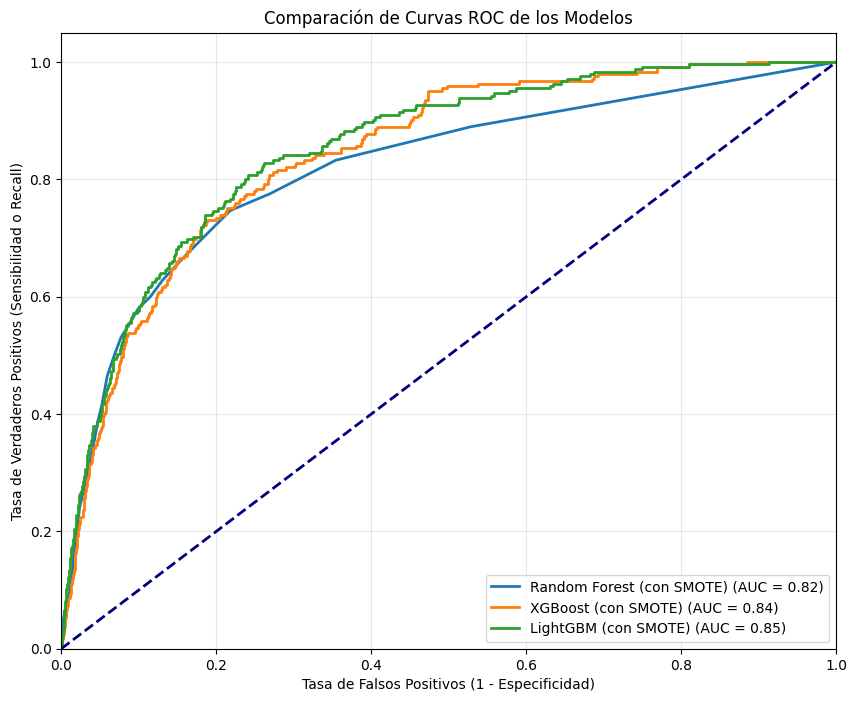

In [59]:
# --- 5. Comparación Gráfica de Curvas ROC ---
print("\n--- 4.5 Comparación Gráfica de Curvas ROC ---")

plt.figure(figsize=(10, 8))
for model_name, res_data in results.items():
    fpr, tpr, _ = roc_curve(y_test, res_data['y_pred_proba'])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad o Recall)')
plt.title('Comparación de Curvas ROC de los Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

> Aunque la aplicación de SMOTE ha permitido que los modelos comiencen a identificar algunos casos de default, el rendimiento actual sigue siendo insuficiente para su uso fiable en un contexto de auditoría para la detección de defaults. El principal problema es el recall extremadamente bajo (2%) para la clase Default (1), lo que significa que la gran mayoría de los riesgos reales no están siendo detectados.

> Los valores de AUC-ROC, especialmente para LightGBM y XGBoost, son prometedores e indican que los modelos tienen cierto poder discriminatorio subyacente. Sin embargo, la configuración actual (probablemente el umbral de decisión) impide que este poder se traduzca en una identificación efectiva de los defaults.



#VERIFICACIÓN DEL CUMPLIMIENTO DE LA LEY 26.951 ("NO LLAME")

---



*Revisión de la Ley 26.951 y diseño de un procedimiento de muestreo aleatorio estratificado para la posterior verificación por parte del Banco del cumplimiento con el Registro "No Llame".

# 5- No me llame

Construir un modelo que, basándose en las características de la campaña y el historial de contacto, pueda predecir la probabilidad de que una llamada específica sea considerada "inapropiada" o un "mal llamado".

Supuestos:
* Se espera que el 7,5% de la base haya sido una mal llamada, y se asigna de manera aleatoria en toda la base.


Mecanismo de muestreo:  seleccion aleatroia de las partidas potencialmente que se llamo y correspondia no llamar, no me llame = 1, cantidad de partidas a muestrear 40 (se supera el limite de realizar 5 por mil aporx 229 partidas)

Se procedió:

1. Se identifica la prediccion a una relacion el 7,5%

2. Distribución de 'llamado_mal'

3. Total de registros con 'llamado_mal == 1' y seleccion aleatoria de 40 casos.

4. Visualizacion de la muestra en datos originales

In [60]:
print("\n--- 5.1 Se identifica la prediccion a una relacion el 7,5% ---")
np.random.seed(42) #Se fija la semilla
X['llamado_mal'] = np.random.choice([0, 1], size=len(X), p=[0.925, 0.075]) # 7,5% "llamado mal" se estima

print(f"\n --- 5.2 Distribución de 'llamado_mal':\n{X['llamado_mal'].value_counts(normalize=True)}")

if X['llamado_mal'].nunique() < 2:
    raise ValueError("La variable objetivo 'llamado_mal' no tiene al menos dos clases. Verifica su creación.")
if X['llamado_mal'].isnull().any():
    raise ValueError("La variable objetivo 'llamado_mal' contiene valores nulos.")



--- 5.1 Se identifica la prediccion a una relacion el 7,5% ---

 --- 5.2 Distribución de 'llamado_mal':
llamado_mal
0    0.924686
1    0.075314
Name: proportion, dtype: float64


In [61]:
df_llamados_malos = X[X['llamado_mal'] == 1].copy() # Se utiliza .copy() para evitar warnings

print(f"\n--- 5.3 Total de registros con 'llamado_mal == 1': {len(df_llamados_malos)}")

numero_muestras_deseadas = 40
df_muestra_llamados_malos = pd.DataFrame() # Inicializar DataFrame vacío

if len(df_llamados_malos) == 0:
    print("\nNo se encontraron registros con 'llamado_mal == 1'. No se puede tomar la muestra.")
elif len(df_llamados_malos) < numero_muestras_deseadas:
    print(f"\nSe encontraron solo {len(df_llamados_malos)} registros con 'llamado_mal == 1' (menos de los {numero_muestras_deseadas} deseados).")
    print("Se seleccionarán todos estos registros.")
    df_muestra_llamados_malos = df_llamados_malos.sample(n=len(df_llamados_malos), random_state=777) # Tomar todos, random_state para orden consistente
else:
    print(f"\nSeleccionando {numero_muestras_deseadas} registros al azar de los {len(df_llamados_malos)} casos con 'llamado_mal == 1'.")
    df_muestra_llamados_malos = df_llamados_malos.sample(n=numero_muestras_deseadas, random_state=777) # random_state para reproducibilidad

print(f"\n--- Muestra de {len(df_muestra_llamados_malos)} Partidas donde 'llamado_mal == 1' ---")
df_muestra_llamados_malos


--- 5.3 Total de registros con 'llamado_mal == 1': 3405

Seleccionando 40 registros al azar de los 3405 casos con 'llamado_mal == 1'.

--- Muestra de 40 Partidas donde 'llamado_mal == 1' ---


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,llamado_mal
35603,52.0,4.0,1.0,2.0,0.0,249.0,1.0,1.0,2.0,7.0,5.0,100.0,1.0,-1.0,0.0,0.0,1
34640,43.0,7.0,1.0,1.0,0.0,122.0,1.0,0.0,1.0,5.0,5.0,355.0,2.0,-1.0,0.0,0.0,1
35971,50.0,7.0,0.0,1.0,0.0,81.0,0.0,0.0,1.0,8.0,5.0,746.0,2.0,-1.0,0.0,0.0,1
18743,43.0,7.0,1.0,1.0,0.0,642.0,0.0,0.0,1.0,31.0,7.0,644.0,2.0,-1.0,0.0,0.0,1
8943,39.0,1.0,1.0,0.0,0.0,104.0,1.0,0.0,0.0,4.0,6.0,624.0,2.0,-1.0,0.0,0.0,1
33756,69.0,5.0,0.0,2.0,0.0,247.0,0.0,0.0,1.0,22.0,4.0,138.0,2.0,-1.0,0.0,0.0,1
23681,42.0,6.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,28.0,8.0,35.0,13.0,-1.0,0.0,0.0,1
42198,79.0,5.0,1.0,1.0,0.0,2661.0,0.0,0.0,1.0,10.0,11.0,254.0,5.0,-1.0,0.0,0.0,1
20348,31.0,6.0,2.0,1.0,0.0,762.0,0.0,0.0,1.0,11.0,8.0,312.0,3.0,-1.0,0.0,0.0,1
31279,26.0,8.0,2.0,1.0,0.0,598.0,0.0,0.0,1.0,6.0,3.0,136.0,1.0,-1.0,0.0,0.0,1


In [58]:
print("\n--- 5.4 Visualizacion de la muestra en datos originales")

indices_para_buscar_en_X0 = df_muestra_llamados_malos.index
df_datos_originales_de_la_muestra = X_0.loc[indices_para_buscar_en_X0]

df_datos_originales_de_la_muestra

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
35603,52,management,married,tertiary,no,249,yes,yes,telephone,7,may,100,1,-1,0,NaN
34640,43,services,married,secondary,no,122,yes,no,cellular,5,may,355,2,-1,0,NaN
35971,50,services,divorced,secondary,no,81,no,no,cellular,8,may,746,2,-1,0,NaN
18743,43,services,married,secondary,no,642,no,no,cellular,31,jul,644,2,-1,0,NaN
8943,39,blue-collar,married,primary,no,104,yes,no,NaN,4,jun,624,2,-1,0,NaN
33756,69,retired,divorced,tertiary,no,247,no,no,cellular,22,apr,138,2,-1,0,NaN
23681,42,self-employed,married,tertiary,no,0,no,no,cellular,28,aug,35,13,-1,0,NaN
42198,79,retired,married,secondary,no,2661,no,no,cellular,10,nov,254,5,-1,0,NaN
20348,31,self-employed,single,secondary,no,762,no,no,cellular,11,aug,312,3,-1,0,NaN
31279,26,student,single,NaN,no,598,no,no,cellular,6,mar,136,1,-1,0,NaN
